In [1]:
suppressPackageStartupMessages({library(Rtsne)
library(dplyr)
library(viridis)
library(gridExtra)
library(devtools)
library(reshape2)})

DelayedArray:::set_verbose_block_processing(TRUE)
options(DelayedArray.block.size=1000e6)

load_all('~/bin/monocle-dev/')

source("../full_TH_scRNA-seq/monocle_help_functions.R")

In [2]:
load_all('~/bin/monocle-dev/')

Loading monocle
Loading required package: Matrix
Loading required package: DelayedArray
Loading required package: stats4
Loading required package: matrixStats

Attaching package: ‘matrixStats’

The following object is masked from ‘package:dplyr’:

    count

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from

In [12]:
# read in some helpful tables of data 

table1 <- read.csv("Kemmeren_etal_Cell_table1.csv")

In [13]:
head(table1)

gene orf.name
1 ASE1 YOR058C 
2 CIS1 YDR022C 
3 BCK2 YER167W 
4 BFA1 YJR053W 
5 BIK1 YCL029C 
6 BIM1 YER016W 
  description                                                                                                                                                                                                                                  
1 Mitotic spindle midzone localized microtubule-associated protein (MAP) family member; required for spindle elongation and stabilization; undergoes cell cycle-regulated degradation by anaphase promoting complex; potential Cdc28p substrate
2 Autophagy-specific protein required for autophagosome formation; may form a complex with Atg17p and Atg29p that localizes other proteins to the pre-autophagosomal structure; high-copy suppressor of CIK1 deletion                          
3 Protein rich in serine and threonine residues involved in protein kinase C signaling pathway, which controls cell integrity; overproduction suppresses pkc1 mutations                                                                        
4 Component of the GTPase-activating Bfa1p-Bub2p complex involved in multiple cell cycle checkpoint pathways that control exit from mitosis                                                                                                    
5 Microtubule-associated protein, component of the interface between microtubules and kinetochore, involved in sister chromatid separation; essential in polyploid cells but not in haploid or diploid cells; ortholog of mammalian CLIP-170   
6 Microtubule-binding protein that together with Kar9p makes up the cortical microtubule capture site and delays the exit from mitosis when the spindle is oriented abnormally                                                                 
  functional.category   responsive_non.responsive nr_sign_changes X  X.1 X.2
1 cell cycle regulation responsive mutant         10              NA NA  NA 
2 cell cycle regulation non-responsive mutant      1              NA NA  NA 
3 cell cycle regulation non-responsive mutant      2              NA NA  NA 
4 cell cycle regulation non-responsive mutant      0              NA NA  NA 
5 cell cycle regulation responsive mutant          4              NA NA  NA 
6 cell cycle regulation responsive mutant         29              NA NA  NA

In [14]:
md_table <- read.table("R_objects/umap_clust50_withNames.txt")

In [15]:
head(md_table)

strain Size_Factor umap_1   umap_2   louvain_component Cluster strain.sys
1 SWD1   1.012636    14.30677 13.85780 1                 30      YAR003W   
2 PTC1   1.016470    14.41301 14.26965 1                 10      YDL006W   
3 TLC1   1.037926    13.97485 14.79885 1                  2      TER1      
4 RAD16  1.001766    14.04112 14.50654 1                  3      YBR114W   
5 MSN2   1.002654    14.32050 14.18458 1                  8      YMR037C   
6 PTR2   1.000428    14.30666 14.56545 1                  9      YKR093W

In [ ]:
# # make column for cell type that starts will all unknowns, we will change these as we figure out cluster cell-types
# pData(cds)$strain = rep("unknown", ncol(cds))
# pData(cds)$Cell_type3 = with(pData(cds), ifelse(Cluster == 1, "Pigment Progenitor", Cell_type3))

In [3]:
cds <- readRDS("R_objects/deltxn_UMAP_2D_50clust.rds")

In [25]:
tmp <- as.data.frame(stringr::str_split_fixed(as.character(pData(cds)$strain), ".del.", 2))

In [30]:
tmp$gene <- toupper(as.character(tmp$V1))

In [33]:
setdiff(tmp$gene, md_table$strain)

[1] "ATG6"           "SHA3"           "CAF17"          "YIL014C.A"     
 [5] "MF.ALPHA.2"     "KEM1"           "YOL086W.A"      "NOT4"          
 [9] "RIS1"           "MED5"           "ATG24"          "MED3"          
[13] "CSN12"          "CHF2"           "FRA2"           "MED12"         
[17] "FMP38"          "AIM1"           "MED18"          "HPA1"          
[21] "CHF1"           "MUC1"           "KRH2"           "SET7"          
[25] "MED15"          "MED16"          "MF.ALPHA.1"     "MED9"          
[29] "ABC1"           "YMR031C.VS..WT" "CTH2"           "HPR5"          
[33] "ARG5.6"         "MED13"          "CAC1"           "KRH1"          
[37] "YDR034W.B"      "SSN6"           "YAL044W.A"      "MED31"         
[41] "MED20"          "CDK8"           "HSN1"           "CYCC"          
[45] "CAP"

In [ ]:
md_table[grep("med", fData(cds)$gene_short_name),]

In [34]:
head(fData(cds))

id      gene_short_name
YMR056C YMR056C AAC1           
YBR085W YBR085W AAC3           
YJR155W YJR155W AAD10          
YNL331C YNL331C AAD14          
YOL165C YOL165C AAD15          
YCR107W YCR107W AAD3

In [35]:
head(pData(cds))

strain                    Size_Factor umap_1  
swd1.del.matA.vs..wt.matA swd1.del.matA.vs..wt.matA 1.012636    14.30677
ptc1.del.vs..wt           ptc1.del.vs..wt           1.016470    14.41301
tlc1.del.vs..wt           tlc1.del.vs..wt           1.037926    13.97485
rad16.del.vs..wt          rad16.del.vs..wt          1.001766    14.04112
msn2.del.vs..wt           msn2.del.vs..wt           1.002654    14.32050
ptr2.del.vs..wt           ptr2.del.vs..wt           1.000428    14.30666
                          umap_2   louvain_component Cluster
swd1.del.matA.vs..wt.matA 13.85780 1                 30     
ptc1.del.vs..wt           14.26965 1                 10     
tlc1.del.vs..wt           14.79885 1                 2      
rad16.del.vs..wt          14.50654 1                 3      
msn2.del.vs..wt           14.18458 1                 8      
ptr2.del.vs..wt           14.56545 1                 9

In [ ]:
pData(pigment_cds)$mito.sum = Matrix::colSums(mito.mat)

pData(pigment_cds)$mito.frac = with(pData(pigment_cds), mito.sum / total_umis)

In [64]:
cds <- updateCDS(cds)
cds <- estimateSizeFactors(cds)

In [17]:
pdf("Plots/pca_var.pdf")
plot_pc_variance_explained(cds, return_all = F)
dev.off()

png 
  2

In [90]:
cds <- preprocessCDS(cds, method = "PCA", 
                   norm_method = 'log',
                   num_dim = 100, 
                   verbose = T)

Remove noise by PCA ...


In [121]:
cds <- reduceDimension(cds, 
                          max_components = 2, #make 3 for 3D
                          n_neighbors=10L, 
                          min_dist=0.05, 
                          metric="cosine", 
                          reduction_method = 'UMAP',
                          norm_method = 'log',
                          verbose = T)

Retrieving normalized data ...
Running Uniform Manifold Approximation and Projection


In [122]:
# use for umap 2D (adds coordinates to pData)
pData(cds)$umap_1 = reducedDimS(cds)[1,]
pData(cds)$umap_2 = reducedDimS(cds)[2,]

In [123]:
cds <- clusterCells(cds, verbose = T, method = "louvain", res = 1e-4, k = 3)

Run kNN based graph clustering starts:
  -Input data of 1484 rows and 2 columns
  -k is set to 3


  Finding nearest neighbors...DONE ~ 0.005 s
  Compute jaccard coefficient between nearest-neighbor sets ...DONE ~ 0.001 s
  Build undirected graph from the weighted links ...DONE ~ 0.003 s
  Run louvain clustering on the graph ...
Running louvain iteration  1 ...


Current iteration is 1; current resolution is 1e-04; Modularity is 0.90904516751065; Number of clusters are 50
Maximal modularity is 0.90904516751065; corresponding resolution is 1e-04

Run kNN based graph clustering DONE, totally takes 0.155498743057251 s.


  -Number of clusters: 50 


Warning message:
“Removed 3 rows containing missing values (geom_text).”

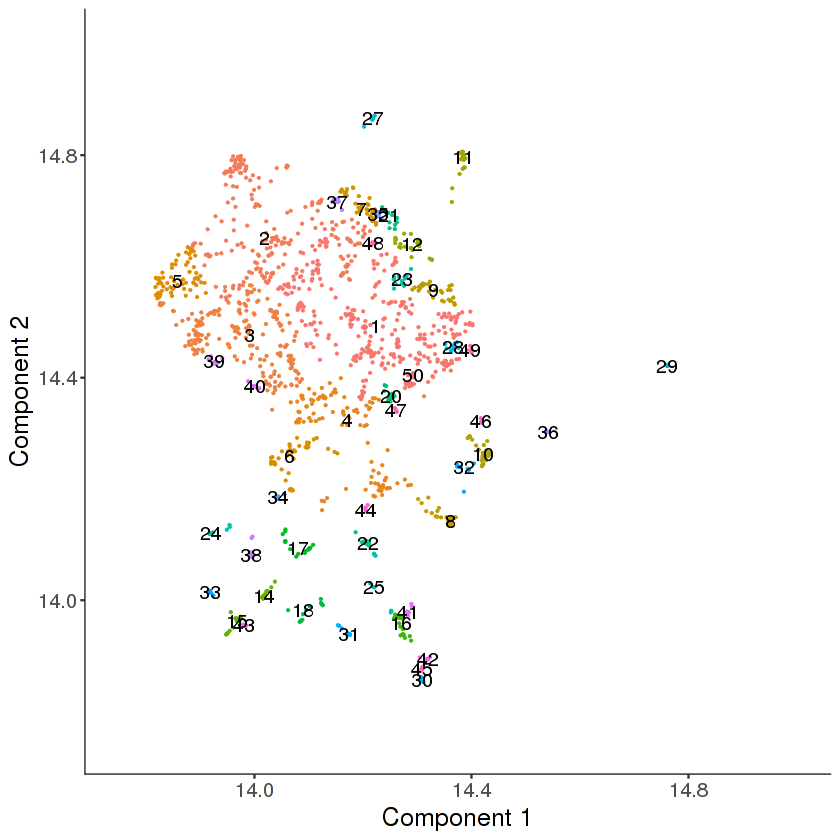

In [126]:
plot_cell_clusters(cds, color_by = "Cluster", cell_size = 0.5, show_group_id = TRUE) +
    theme(legend.position = "none") +
    ylim(13.75,15) +
    xlim(13.75,15)

   # ylim(14.3,15.3) +
   # xlim(14,15)

In [125]:
pData(cds) %>% write.csv("deltxn_UMAP_coords_50clust.csv", row.names= FALSE)

In [128]:
#saveRDS(cds, "R_objects/deltxn_UMAP_2D_50clust.rds")

### Run spatial DE test and parse by cell types/clusters

In [10]:
spatial_res <- readRDS("R_objects/180924_yeast-del_spatial-res.rds")

In [127]:
# spatial_res <- principalGraphTest(cds, relative_expr = TRUE, k = 5,
#                                   cores = 10, verbose = FALSE)
# saveRDS(spatial_res, "R_objects/180924_yeast-del_spatial-res.rds")

  |                                                            |   0%, ETA NA

ERROR: Error in readBin(progressFifo, "integer", n = 100): invalid connection


ERROR: Error in close.connection(progressFifo): invalid connection


In [11]:
cluster_marker_res <- find_cluster_markers(cds, spatial_res, 
                                           group_by = 'Cluster', 
                                           morans_I_threshold = 0.25)

In [15]:
range(cluster_marker_res$specificity)

[1] 0.4711766 0.4711766

In [12]:
cluster_marker_res %>% filter(Group == 27, percentage > 0.3) %>% arrange(-specificity) %>% head(20)

Group Gene    gene_short_name specificity morans_I  morans_test_statistic
1  27    YEL059W HHY1            0.4711766   0.7490568 51.73702             
2  27    YIL029C YIL029C         0.4711766   0.7268710 48.59690             
3  27    YHR005C GPA1            0.4711766   0.7162890 48.44709             
4  27    YOL154W ZPS1            0.4711766   0.7116238 47.50138             
5  27    YDR133C YDR133C         0.4711766   0.6939280 45.95380             
6  27    YGL256W ADH4            0.4711766   0.6922564 46.19971             
7  27    YGL045W RIM8            0.4711766   0.6895679 46.19640             
8  27    YEL060C PRB1            0.4711766   0.6852836 45.48765             
9  27    YDR446W ECM11           0.4711766   0.6847294 47.11564             
10 27    YPL277C YPL277C         0.4711766   0.6841267 45.83982             
11 27    YJR061W YJR061W         0.4711766   0.6827441 45.72495             
12 27    YJL038C LOH1            0.4711766   0.6777546 46.11225             
13 27    YOR389W YOR389W         0.4711766   0.6743134 45.11078             
14 27    YKL175W ZRT3            0.4711766   0.6663801 44.13650             
15 27    YBR182C SMP1            0.4711766   0.6638936 44.88756             
16 27    YLR413W YLR413W         0.4711766   0.6635257 43.97482             
17 27    YGL159W YGL159W         0.4711766   0.6608840 44.09106             
18 27    YLL005C SPO75           0.4711766   0.6576653 45.36964             
19 27    YAL018C YAL018C         0.4711766   0.6538909 47.43334             
20 27    YJR078W BNA2            0.4711766   0.6522404 43.14471             
   pval qval mean     num_cells_expressed_in_group percentage status id     
1  0    0    4.716061 11                           1          OK     YEL059W
2  0    0    4.776829 11                           1          OK     YIL029C
3  0    0    3.410247 11                           1          OK     YHR005C
4  0    0    4.761397 11                           1          OK     YOL154W
5  0    0    4.680446 11                           1          OK     YDR133C
6  0    0    4.722549 11                           1          OK     YGL256W
7  0    0    4.713617 11                           1          OK     YGL045W
8  0    0    4.740178 11                           1          OK     YEL060C
9  0    0    4.757501 11                           1          OK     YDR446W
10 0    0    4.681289 11                           1          OK     YPL277C
11 0    0    4.681289 11                           1          OK     YJR061W
12 0    0    4.775296 11                           1          OK     YJL038C
13 0    0    4.693847 11                           1          OK     YOR389W
14 0    0    4.741765 11                           1          OK     YKL175W
15 0    0    4.744932 11                           1          OK     YBR182C
16 0    0    4.776063 11                           1          OK     YLR413W
17 0    0    4.749664 11                           1          OK     YGL159W
18 0    0    4.741765 11                           1          OK     YLL005C
19 0    0    4.733803 11                           1          OK     YAL018C
20 0    0    4.730601 11                           1          OK     YJR078W

In [164]:
cluster_marker_res %>% filter(gene_short_name == "mmp")

Group Gene gene_short_name specificity morans_I morans_test_statistic pval
     qval mean num_cells_expressed_in_group percentage status id
     num_cells_expressed

In [ ]:
cluster_marker_res %>% filter(percentage > 0.05, qval < 0.05) %>% arrange(-specificity) %>%
    select(Cell_type = Group, everything()) %>%
    write.csv("all-cells_zg11_umap3D_cell-type-markers.csv")

In [23]:
plot_grey_marker_umap_legend = function (cds, marker) {
    cds_subset <- cds[fData(cds)$gene_short_name == marker, ]
    marker_expr <- Matrix::t(exprs(cds_subset))/pData(cds_subset)$Size_Factor
    pData(cds_subset)$marker <- as.numeric(marker_expr[, 1])
    pData(cds_subset)$marker = with(pData(cds_subset), ifelse(marker >= 
        0.01, marker, NA))
    color_str <- paste0(marker)
    ggplot(pData(cds_subset), aes(x = umap_1, y = umap_2, color = marker)) + 
    geom_point(size = 0.5, aes(alpha = ifelse(!is.na(marker), 
        "1", "2"))) + scale_color_viridis(option = "viridis", 
        direction = 1, name = color_str, na.value = "grey80") + scale_alpha_manual(values = c(1, 0.5)) + 
        guides(alpha = FALSE) + theme_void() + theme(legend.position = "right")
}

Warning message:
“Removed 48 rows containing missing values (geom_point).”

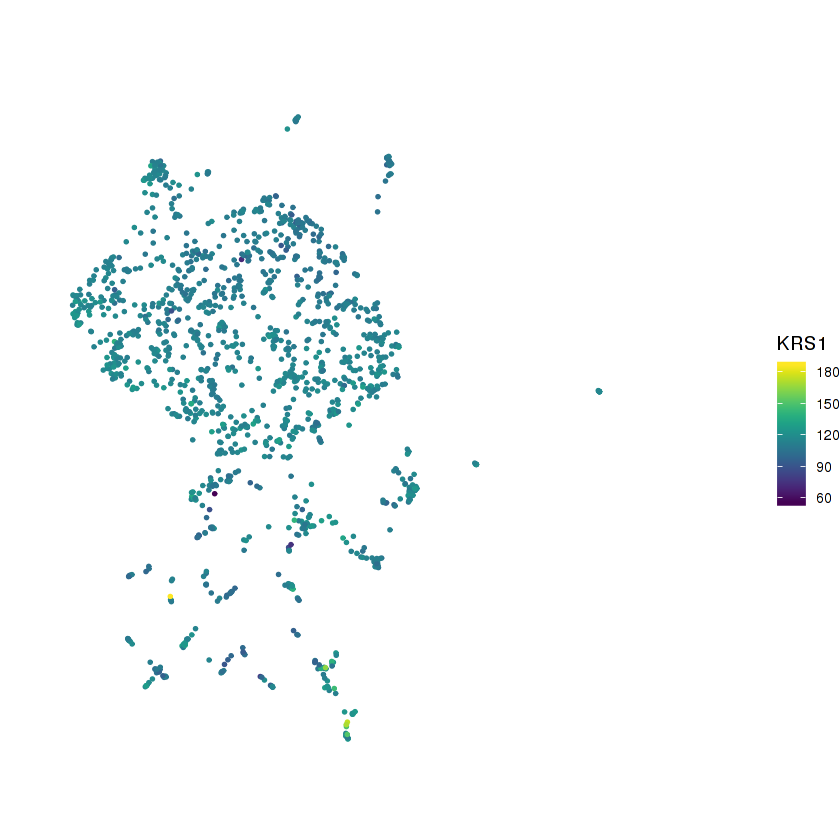

In [31]:
plot_grey_marker_umap_legend(cds, "STE12") +
    ylim(13.75,15) +
    xlim(13.75,15)

### Remove muscle contaminants

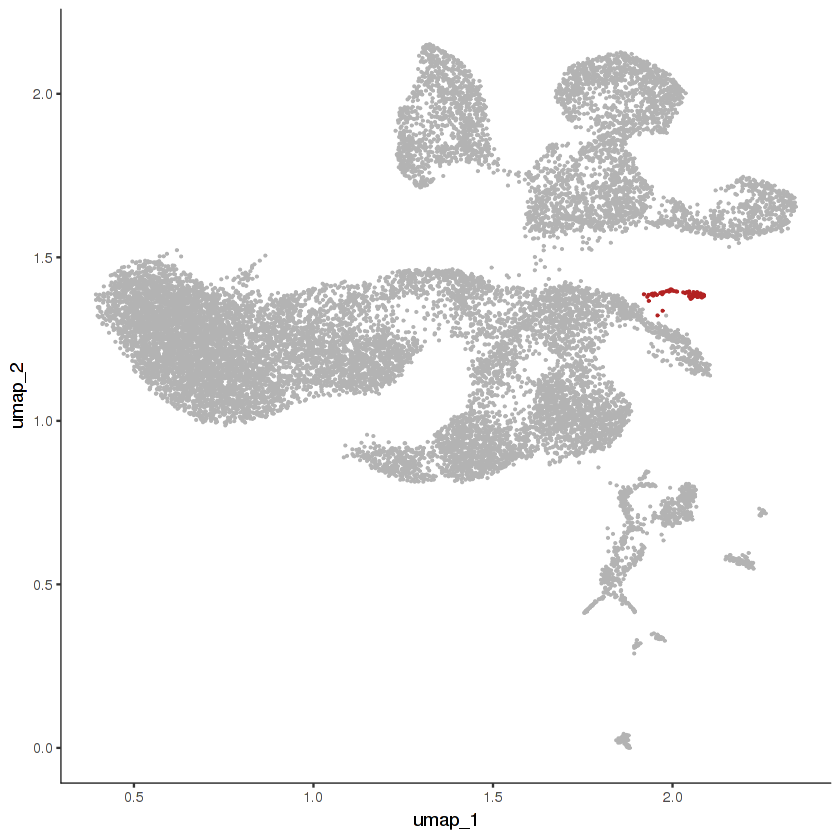

In [30]:
ggplot(pData(NC_cds), aes(x = umap_1, y = umap_2, color = Cluster == 5 & umap_1 > 1.92)) +
    geom_point(size = 0.1) +
    scale_color_manual(values = c("grey70", "firebrick")) +
    guides(color = F) +
    monocle:::monocle_theme_opts()

In [42]:
# make column for cell type that starts will all unknowns, 
pData(NC_cds)$Contam = rep("unknown", ncol(NC_cds))

In [43]:
# assign doublet status to the cells so that they can be removed
pData(NC_cds)$Contam = with(pData(NC_cds), ifelse(Cluster == 5 & umap_1 > 1.92, "Myog expr cell", Contam))

In [ ]:
# remove doublets and re-run dimensionality reduction (assigned below)
NC_cds <- NC_cds[, !(pData(NC_cds)$Contam == "Myog expr cell")]

### Remove schwann cell/Xanthophore doublets

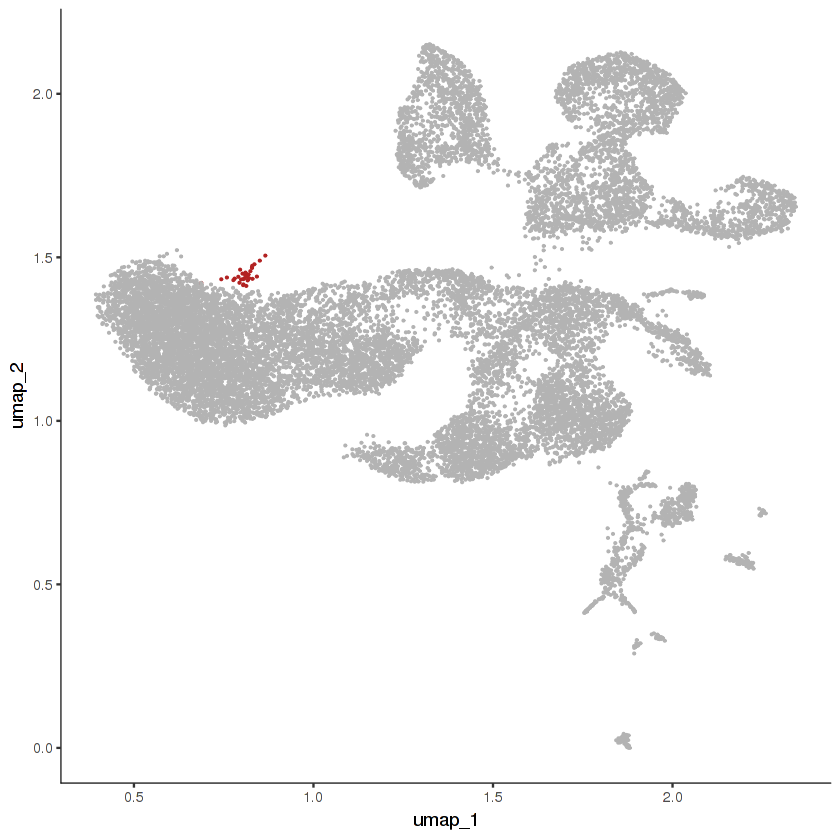

In [39]:
ggplot(pData(NC_cds), aes(x = umap_1, y = umap_2, color = Cluster == 1 & umap_2 > 1.41)) +
    geom_point(size = 0.1) +
    scale_color_manual(values = c("grey70", "firebrick")) +
    guides(color = F) +
    monocle:::monocle_theme_opts()

In [44]:
# assign doublet status to the cells so that they can be removed
pData(NC_cds)$Contam = with(pData(NC_cds), ifelse(Cluster == 1 & umap_2 > 1.41, "Schwann Xan doublet", Contam))

In [45]:
pData(NC_cds) %>% filter(Contam != "unknown") %>% nrow() 

[1] 105

In [46]:
dim(pData(NC_cds))

[1] 16450    14

In [48]:
# remove doublets and re-run dimensionality reduction (assigned below)
NC_cds <- NC_cds[, !(pData(NC_cds)$Contam %in% c("Schwann Xan doublet", "Myog expr cell"))]

In [49]:
dim(pData(NC_cds))

[1] 16345    14

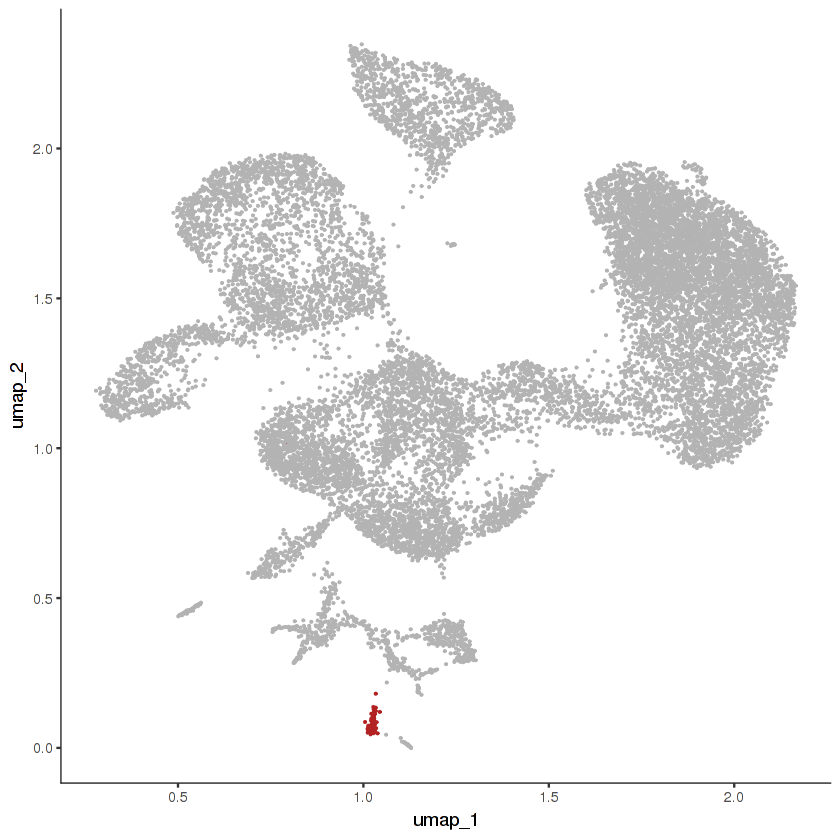

In [168]:
#
ggplot(pData(NC_cds_old), aes(x = umap_1, y = umap_2, color = barcode %in% subset(pData(NC_cds), Cluster == 20)$barcode)) +
    geom_point(size = 0.1) +
    scale_color_manual(values = c("grey70", "firebrick")) +
    guides(color = F) +
    monocle:::monocle_theme_opts()

In [165]:
pData(NC_cds)$barcode = paste(sub("-[0-9]+_500-bp_aggr", "", pData(NC_cds)$cell), pData(NC_cds)$sample, sep = "_")
pData(NC_cds_old)$barcode = paste(sub("-[0-9]+_aggregated_samples_pigment", "", pData(NC_cds_old)$cell), pData(NC_cds_old)$sample, sep = "_")

In [166]:
head(pData(NC_cds_old))

cell                                         
AAACCTGTCCAGTATG-1_aggregated_samples_pigment AAACCTGTCCAGTATG-1_aggregated_samples_pigment
AAACGGGAGTGAACAT-1_aggregated_samples_pigment AAACGGGAGTGAACAT-1_aggregated_samples_pigment
AAACGGGCACTTACGA-1_aggregated_samples_pigment AAACGGGCACTTACGA-1_aggregated_samples_pigment
AAACGGGCATCCGTGG-1_aggregated_samples_pigment AAACGGGCATCCGTGG-1_aggregated_samples_pigment
AAACGGGGTAGGCATG-1_aggregated_samples_pigment AAACGGGGTAGGCATG-1_aggregated_samples_pigment
AAAGATGCACCACCAG-1_aggregated_samples_pigment AAAGATGCACCACCAG-1_aggregated_samples_pigment
                                              total_umis sample   TSNE.1     
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 1871       euth_juv  0.05580176
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 1816       euth_juv -4.41935733
AAACGGGCACTTACGA-1_aggregated_samples_pigment 1795       euth_juv -3.60241005
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 1932       euth_juv -2.19400028
AAACGGGGTAGGCATG-1_aggregated_samples_pigment  932       euth_juv -3.84655397
AAAGATGCACCACCAG-1_aggregated_samples_pigment 1228       euth_juv -3.95498689
                                              TSNE.2     Size_Factor condition
AAACCTGTCCAGTATG-1_aggregated_samples_pigment  -7.909065 1.2452660   euth     
AAACGGGAGTGAACAT-1_aggregated_samples_pigment -38.150876 1.2086601   euth     
AAACGGGCACTTACGA-1_aggregated_samples_pigment  -7.720802 1.1946833   euth     
AAACGGGCATCCGTGG-1_aggregated_samples_pigment  -9.502526 1.2858652   euth     
AAACGGGGTAGGCATG-1_aggregated_samples_pigment  -7.265528 0.6203035   euth     
AAAGATGCACCACCAG-1_aggregated_samples_pigment  -8.148889 0.8173098   euth     
                                              num_genes_expressed tsne_1      
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 856                 -11.61818851
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 952                  -0.02569724
AAACGGGCACTTACGA-1_aggregated_samples_pigment 932                 -14.72032980
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 929                 -10.34764926
AAACGGGGTAGGCATG-1_aggregated_samples_pigment 596                 -13.50423409
AAAGATGCACCACCAG-1_aggregated_samples_pigment 722                 -12.69432238
                                              tsne_2    ... peaks halo
AAACCTGTCCAGTATG-1_aggregated_samples_pigment  3.930498 ... FALSE TRUE
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 43.828776 ... FALSE TRUE
AAACGGGCACTTACGA-1_aggregated_samples_pigment  7.265939 ... FALSE TRUE
AAACGGGCATCCGTGG-1_aggregated_samples_pigment  5.885679 ... FALSE TRUE
AAACGGGGTAGGCATG-1_aggregated_samples_pigment  6.213567 ... FALSE TRUE
AAAGATGCACCACCAG-1_aggregated_samples_pigment  6.968753 ... FALSE TRUE
                                              delta       rho      Cell_type   
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 0.005269650 165.4461 Glia        
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 0.009346752 250.8803 Schwann Cell
AAACGGGCACTTACGA-1_aggregated_samples_pigment 0.008977446 131.2548 Glia        
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 0.002068659 110.9793 Glia        
AAACGGGGTAGGCATG-1_aggregated_samples_pigment 0.005652243 151.0748 Glia        
AAAGATGCACCACCAG-1_aggregated_samples_pigment 0.010874506 127.7879 Glia        
                                              umap_1   umap_2   
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 1.380155 0.7742559
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 2.103115 1.4577971
AAACGGGCACTTACGA-1_aggregated_samples_pigment 1.420424 0.7723179
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 1.451319 0.8510199
AAACGGGGTAGGCATG-1_aggregated_samples_pigment 1.416179 0.7901413
AAAGATGCACCACCAG-1_aggregated_samples_pigment 1.419930 0.8517757
                                              louvain_component Cell_type_sub
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 1                 Other Glia   
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 1                 Schwann Cell 
AAAC

In [42]:
fData(NC_cds)[grep("insr", fData(NC_cds)$gene_short_name),] %>% arrange(-num_cells_expressed)

id                 gene_short_name num_cells_expressed
1 ENSDARG00000011948 insra           704                
2 ENSDARG00000071524 insrb            35

In [34]:
fData(NC_cds) %>% head()

ERROR: Error in `[.data.frame`(fData(NC_cds), , fData(NC_cds)$id): undefined columns selected


In [37]:
plot.two.genes.id = function (cds, gene1, gene2, thresh = 1) {
    gene.id1 = as.character(fData(cds)[fData(cds)$id == 
        gene1, "id"])
    gene.id2 = as.character(fData(cds)[fData(cds)$id == 
        gene2, "id"])
    if (sum(exprs(cds)[gene.id1, ] >= thresh & Biobase::exprs(cds)[gene.id2, 
        ] >= thresh) > 0) {
        pData(cds)$tmp = ifelse(Biobase::exprs(cds)[gene.id1, ] >= thresh & 
            exprs(cds)[gene.id2, ] >= thresh, "both", ifelse(exprs(cds)[gene.id1, 
            ] >= thresh, gene1, ifelse(exprs(cds)[gene.id2, ] >= 
            thresh, gene2, "neither")))
        pData(cds)$tmp = factor(pData(cds)$tmp, levels = c(gene1, 
            gene2, "both", "neither"))
        plot = ggplot(pData(cds), aes(x = umap_1, y = umap_2, 
            color = tmp)) + geom_point(size = 0.2, aes(alpha = ifelse(exprs(cds)[gene.id1, 
            ] > 0 | exprs(cds)[gene.id2, ] > 0, "1", "2"))) + 
            scale_color_manual(values = c("royalblue3", "firebrick3", 
                "mediumorchid3", "grey80")) + scale_alpha_manual(values = c(1, 
            0.5)) + guides(alpha = FALSE) + guides(colour = guide_legend(override.aes = list(size = 2))) + 
            monocle:::monocle_theme_opts() + theme_void()
    }
    else {
        pData(cds)$tmp = ifelse(exprs(cds)[gene.id1, ] >= thresh, 
            gene1, ifelse(exprs(cds)[gene.id2, ] >= thresh, gene2, 
                "neither"))
        pData(cds)$tmp = factor(pData(cds)$tmp, levels = c(gene1, 
            gene2, "neither"))
        plot = ggplot(pData(cds), aes(x = umap_1, y = umap_2, 
            color = tmp)) + geom_point(size = 0.2, aes(alpha = ifelse(exprs(cds)[gene.id1, 
            ] > 0 | exprs(cds)[gene.id2, ] > 0, "1", "2"))) + 
            scale_color_manual(values = c("royalblue3", "firebrick3", 
                "grey80")) + scale_alpha_manual(values = c(1, 
            0.5)) + guides(alpha = FALSE) + guides(colour = guide_legend(override.aes = list(size = 2))) + 
            monocle:::monocle_theme_opts() + theme_void()
    }
    pData(cds)$tmp = NULL
    return(plot)
}

In [41]:
png("Plots/NC_cds_ncad_ecad_expr.png", width = 6, height = 6, units = "in", res = 500)
plot.two.genes.id(NC_cds, "ENSDARG00000102750", "ENSDARG00000018693")
dev.off()

png 
  2

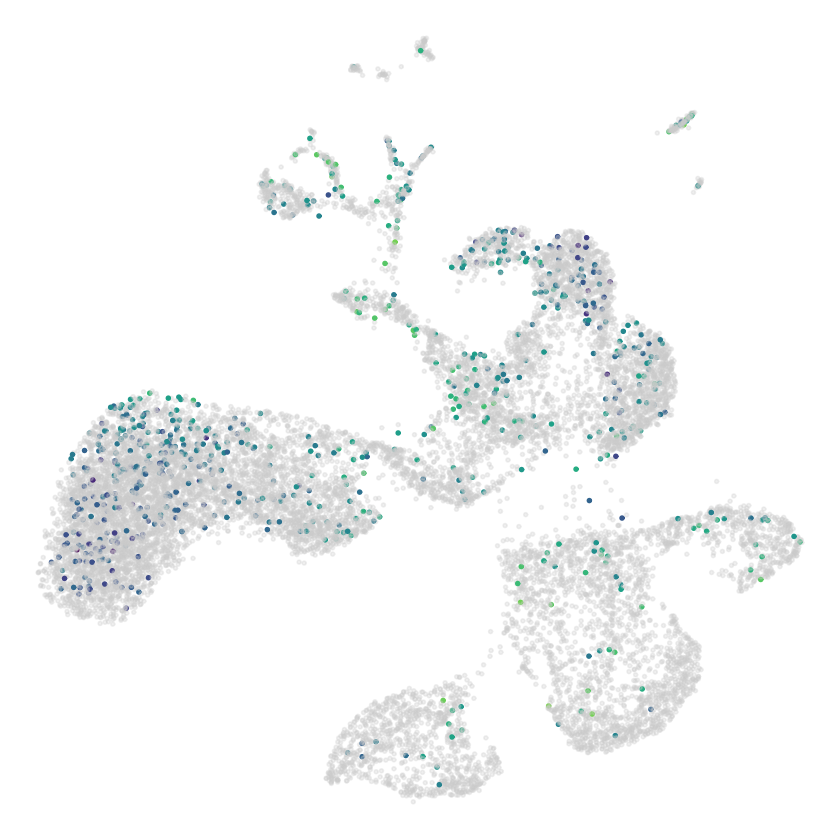

In [43]:
plot_grey_marker_umap(NC_cds, "insra") #+ 
    #facet_wrap(~condition)

In [266]:
NC_cds <- partitionCells(NC_cds)

In [267]:
NC_cds <- learnGraph(NC_cds,  RGE_method = 'SimplePPT',
                  verbose = F, max_components = 3)

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

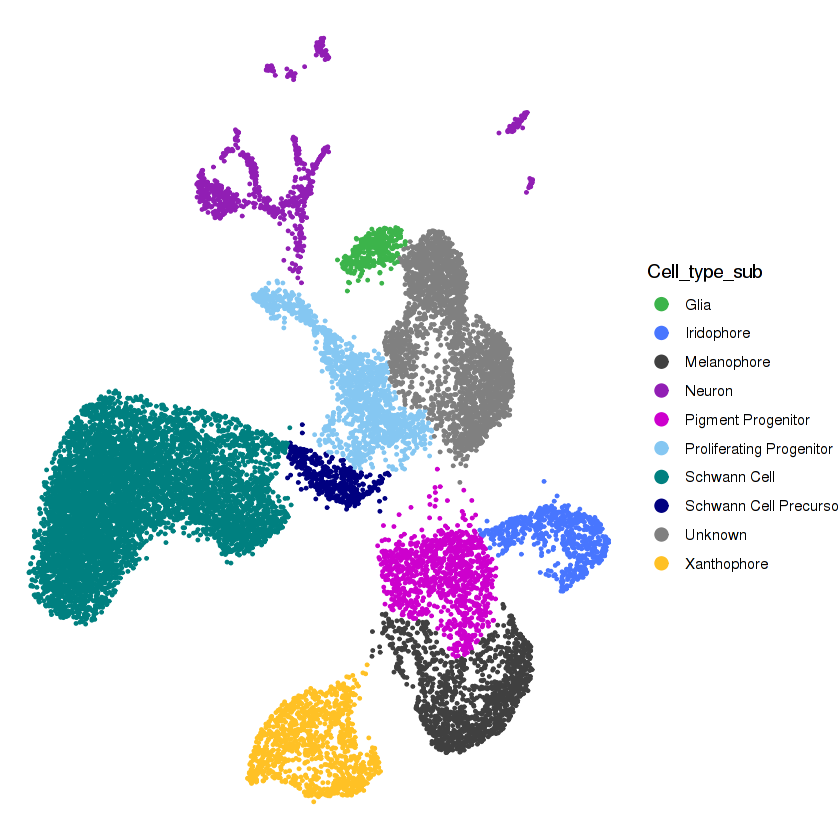

In [9]:
plot_cell_trajectory(NC_cds, color_by = 'Cell_type_sub', cell_size = 0.3, show_backbone = F,show_tree = F) +
    theme_void() +
    theme(legend.position = "right") +
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    scale_color_manual(values = cell.colors.2D) #+
    #ggsave("Plots/euth_hypo_NC-cells_umap2D_celltype.png", units = "in", width = 8, height = 6, dpi = 400)

In [269]:
head(pData(NC_cds))

cell                           total_umis
AAACCTGTCCAGTATG-2_500-bp_aggr AAACCTGTCCAGTATG-2_500-bp_aggr 1930      
AAACGGGAGTGAACAT-2_500-bp_aggr AAACGGGAGTGAACAT-2_500-bp_aggr 1893      
AAACGGGCACTTACGA-2_500-bp_aggr AAACGGGCACTTACGA-2_500-bp_aggr 1883      
AAACGGGCATCCGTGG-2_500-bp_aggr AAACGGGCATCCGTGG-2_500-bp_aggr 1975      
AAACGGGGTAGGCATG-2_500-bp_aggr AAACGGGGTAGGCATG-2_500-bp_aggr  974      
AAAGATGCACCACCAG-2_500-bp_aggr AAAGATGCACCACCAG-2_500-bp_aggr 1256      
                               sample   Size_Factor condition
AAACCTGTCCAGTATG-2_500-bp_aggr euth_juv 1.2878293   euth     
AAACGGGAGTGAACAT-2_500-bp_aggr euth_juv 1.2631404   euth     
AAACGGGCACTTACGA-2_500-bp_aggr euth_juv 1.2564677   euth     
AAACGGGCATCCGTGG-2_500-bp_aggr euth_juv 1.3178564   euth     
AAACGGGGTAGGCATG-2_500-bp_aggr euth_juv 0.6499201   euth     
AAAGATGCACCACCAG-2_500-bp_aggr euth_juv 0.8380900   euth     
                               num_genes_expressed louvain_component Cluster
AAACCTGTCCAGTATG-2_500-bp_aggr 899                 1                 14     
AAACGGGAGTGAACAT-2_500-bp_aggr 987                 1                 1      
AAACGGGCACTTACGA-2_500-bp_aggr 986                 1                 14     
AAACGGGCATCCGTGG-2_500-bp_aggr 952                 1                 14     
AAACGGGGTAGGCATG-2_500-bp_aggr 630                 1                 14     
AAAGATGCACCACCAG-2_500-bp_aggr 737                 1                 14     
                               umap_1    umap_2    umap_3   Cell_type   
AAACCTGTCCAGTATG-2_500-bp_aggr 0.7515346 1.0559157 1.621356 Glia        
AAACGGGAGTGAACAT-2_500-bp_aggr 0.3858269 0.4922276 1.025761 Schwann Cell
AAACGGGCACTTACGA-2_500-bp_aggr 0.7859449 1.0006185 1.646314 Glia        
AAACGGGCATCCGTGG-2_500-bp_aggr 0.7119864 0.9971793 1.549180 Glia        
AAACGGGGTAGGCATG-2_500-bp_aggr 0.7076106 1.0168851 1.638001 Glia        
AAAGATGCACCACCAG-2_500-bp_aggr 0.7051084 1.0219240 1.583906 Glia

In [290]:
plot_3d_cell_trajectory(NC_cds, palette = cell.colors, 
                        image_filename = "/net/trapnell/vol1/home/lsaund11/notebooks/full_TH_scRNA-seq/Plots/NC_umap_test_plot.pdf"
                        color_by= "Cell_type_sub", 
                        webGL_filename= "/net/trapnell/vol1/home/lsaund11/notebooks/full_TH_scRNA-seq/Plots/NC_umap_3D_test.html",
                        show_backbone=FALSE, 
                        useNULL_GLdev=TRUE)

Joining, by = "sample_name"


HTML widgets cannot be represented in plain text (need html)

In [375]:
plot_3d_cell_trajectory(NC_cds, palette = cell.colors, 
                        color_by= "Cell_type_sub", 
                        show_backbone=FALSE,
                    image_filename = "/net/trapnell/vol1/home/lsaund11/notebooks/full_TH_scRNA-seq/Plots/NC_umap_test_plot.png")

Joining, by = "sample_name"


NULL

### Assigning Clusters to 3D umap plot

In [286]:
# make column for cell type that starts will all unknowns, we will change these as we figure out cluster cell-types
pData(NC_cds)$Cell_type_sub = rep("unknown", ncol(NC_cds))

In [287]:
# assign cell-types to clusters as we solve them
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 1, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 2, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 3, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 4, "NC Unknown", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 5, "Proliferating Progenitor", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 6, "Pigment Progenitor", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 7, "Melanophore", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 8, "Xanthophore", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 9, "NC Unknown", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 10, "Iridophore", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 11, "Schwann Cell Precursor", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 12, "Neuron", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 13, "Neuron", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 14, "Glia", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 15, "Neuron", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 16, "Neuron", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 17, "Neuron", Cell_type_sub))

In [281]:
pData(NC_cds) %>% group_by(Cell_type_sub) %>% summarize(Count = n())

Cell_type_sub          Count
1 Glia                   1233 
2 Iridophore              654 
3 Melanophore            1133 
4 NC Unknown             2757 
5 Neuron                 1120 
6 Pigment Progenitor     1137 
7 Schwann Cell           6764 
8 Schwann Cell Precursor  571 
9 Xanthophore            1081

In [364]:
saveRDS(NC_cds, "R_objects/euth_hypo_NC-cells_umap3D_zg11_aggr_cds.rds")

### Assigning cell type to 2D umap plot clusters

They're essentially the same but look a little different so this will be cleaner

In [72]:
# make column for cell type that starts will all unknowns, we will change these as we figure out cluster cell-types
pData(NC_cds)$Cell_type_sub = rep("unknown", ncol(NC_cds))

In [73]:
# assign cell-types to clusters as we solve them
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 1, "Unknown", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 2, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 3, "Pigment Progenitor", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 4, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 5, "Unknown", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 6, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 7, "Proliferating Progenitor", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 8, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 9, "Melanophore", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 10, "Xanthophore", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 11, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 12, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 13, "Iridophore", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 14, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 15, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 16, "Melanophore", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 17, "Schwann Cell Precursor", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 18, "Neuron", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 19, "Xanthophore", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 20, "Glia", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 21, "Unknown", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 22, "Proliferating Progenitor", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 23, "Proliferating Progenitor", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 24, "Neuron", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 25, "Schwann Cell", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 26, "Neuron", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 27, "Neuron", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 28, "Neuron", Cell_type_sub))
pData(NC_cds)$Cell_type_sub = with(pData(NC_cds), ifelse(Cluster == 29, "Neuron", Cell_type_sub))

In [74]:
pData(NC_cds) %>% group_by(Cell_type_sub) %>% summarize(Count = n())

Cell_type_sub            Count
1  Glia                      332 
2  Iridophore                652 
3  Melanophore              1245 
4  Neuron                    871 
5  Pigment Progenitor       1027 
6  Proliferating Progenitor 1381 
7  Schwann Cell             6769 
8  Schwann Cell Precursor    457 
9  Unknown                  2526 
10 Xanthophore              1085

In [75]:
saveRDS(NC_cds, "R_objects/euth_hypo_NC-cells_umap2D_zg11_aggr_cds.rds")

In [6]:
# make custom color assignments
cell.colors.2D <- c("Xanthophore" = "goldenrod1", "Neuron" = "#911eb4", "Iridophore" = "royalblue1",
                "Melanophore" = "gray25", "Glia" = "#3cb44b",
                "Pigment Progenitor" = "magenta3", 
                 "Proliferating Progenitor" = "#85C7F2", "Schwann Cell" = "#008080", 
                "Unknown" = "#808080", "Schwann Cell Precursor" = "#000080")

In [110]:
# make custom color assignments
cell.colors.3D <- c("Xanthophore" = "goldenrod1", "Neuron" = "#911eb4", "Iridophore" = "royalblue1",
                "Melanophore" = "gray15", "Glia" = "#3cb44b",
                "Pigment Progenitor" = "magenta3", 
                 "Proliferating Progenitor" = "#85C7F2", "Schwann Cell" = "#008080", 
                "NC Unknown" = "#808080", "Schwann Cell Precursor" = "#000080")

In [ ]:
ggplot(pData(NC_cds), aes(x = tsne_1, y = tsne_2, color = Cell_type_sub)) +
   geom_point(size = 0.5) +
    scale_colour_manual(values = cell.colors) +
   geom_text(aes(x = median_tsne_1, y = median_tsne_2, label = Cell_type_sub), data = tmp.df,
               size = 6, colour = "black") +
    theme(legend.position="none") +
    monocle:::monocle_theme_opts() +
    ggsave("Plots/euth_hypo_NC-sub_cell-type_overlay.pdf", width = 8, height = 8, dpi = 400)

In [ ]:
ggplot(pData(NC_cds), aes(x = tsne_1, y = tsne_2, color = Cell_type_sub)) +
   geom_point(size = 0.5) +
    scale_colour_manual(values = cell.colors) +
    monocle:::monocle_theme_opts() +
    theme_void() +
    theme(legend.position="none") +
    ggsave("Plots/euth_hypo_all-samples_NC-cell-color_nolabel_poster.png",
           device = "png", width = 7, height = 7, dpi = 600)

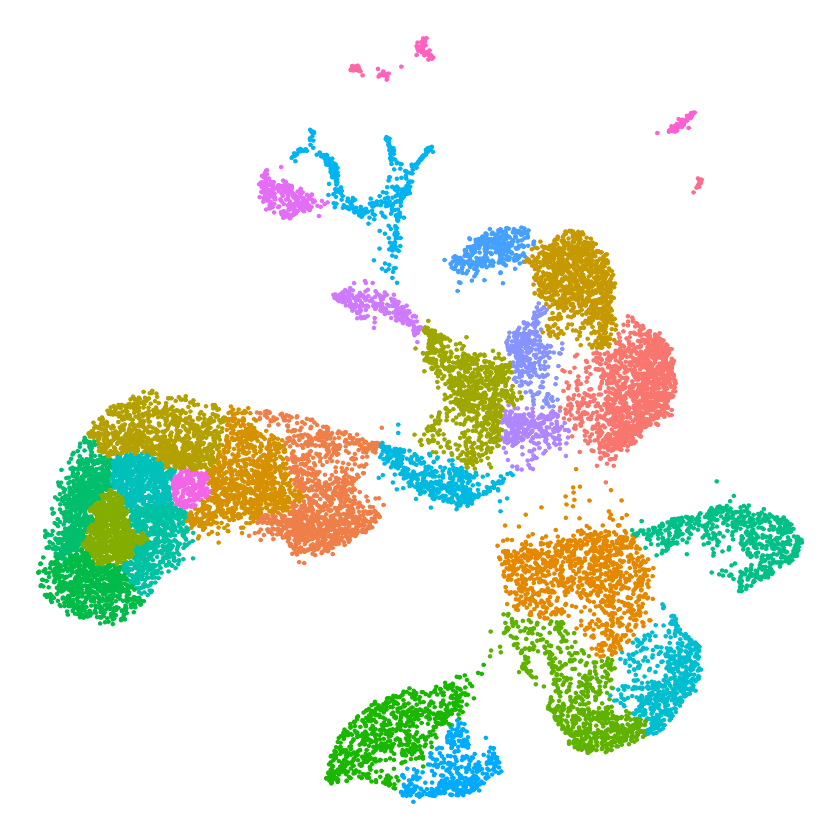

In [8]:
ggplot(pData(NC_cds), aes(x = umap_1, y = umap_2, color = Cluster)) +
   geom_point(size = 0.2) +
    monocle:::monocle_theme_opts() +
    theme_void() +
    theme(legend.position="none") #+
    #ggsave("Plots/euth_hypo_all-samples_NC-cluster-color_nolabel_Fig1B.png",
          # device = "png", width = 3.5, height = 4, dpi = 600)

In [120]:
png("Plots/euth_hypo_all-samples_NC-cell-color_nolabel_Fig1C.png", units = "in", width = 7, height = 8, res = 600)
ggplot(pData(NC_cds), aes(x = umap_1, y = umap_2, color = Cell_type_sub)) +
   geom_point(size = 0.5, alpha = 0.5) +
    scale_colour_manual(values = cell.colors.2D) +
    monocle:::monocle_theme_opts() +
    theme_void() +
    theme(legend.position="none")
dev.off()

png 
  2

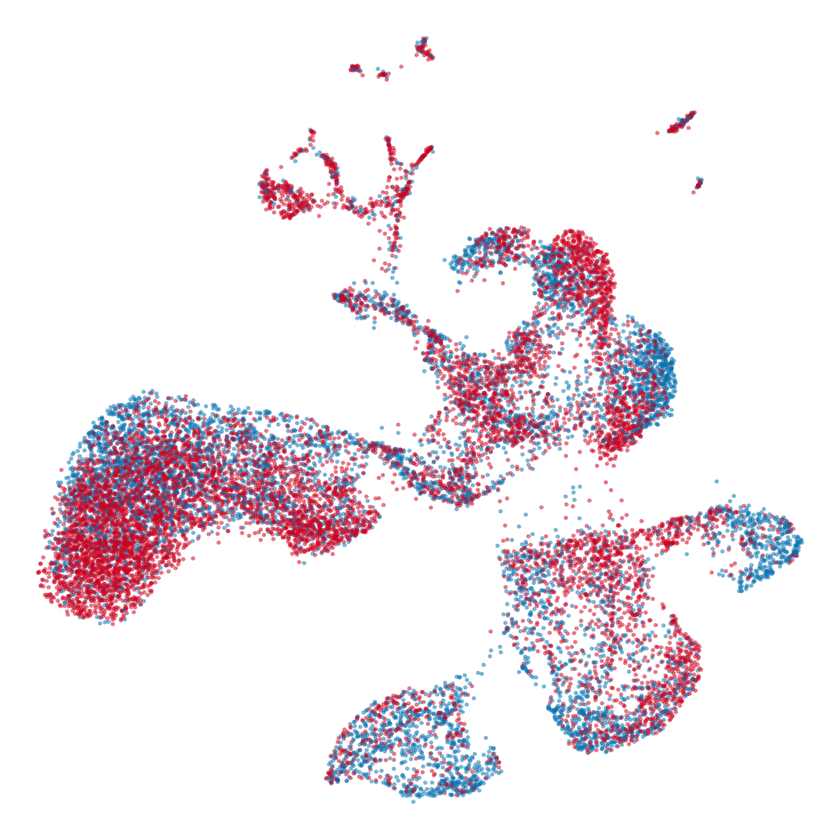

In [79]:
ggplot(pData(NC_cds), aes(x = umap_1, y = umap_2, color = condition)) +
   geom_point(size = 0.2, alpha = 0.4) +
    scale_colour_manual(values = c("#0571b0", "#ca0020")) +
    monocle:::monocle_theme_opts() +
    theme_void() +
    theme(legend.position="none") +
    ggsave("Plots/euth_hypo_all-samples_NC-cell-color_nolabel_Fig1C-2.png",
           device = "png", width = 3.5, height =4, dpi = 600)

### Generate cell and UMI count barplots

In [80]:
tmp <- pData(NC_cds) %>% group_by(Cell_type_sub) %>% summarize(count = n()) %>% arrange(-count)

In [81]:
tmp2 <- pData(NC_cds) %>% group_by(Cell_type_sub) %>% summarize(count = n()) %>% arrange(-count)

In [82]:
tmp$Cell_type_sub <- factor(tmp$Cell_type_sub, levels = rev(tmp$Cell_type_sub))

In [83]:
tmp

Cell_type_sub            count
1  Schwann Cell             6769 
2  Unknown                  2526 
3  Proliferating Progenitor 1381 
4  Melanophore              1245 
5  Xanthophore              1085 
6  Pigment Progenitor       1027 
7  Neuron                    871 
8  Iridophore                652 
9  Schwann Cell Precursor    457 
10 Glia                      332

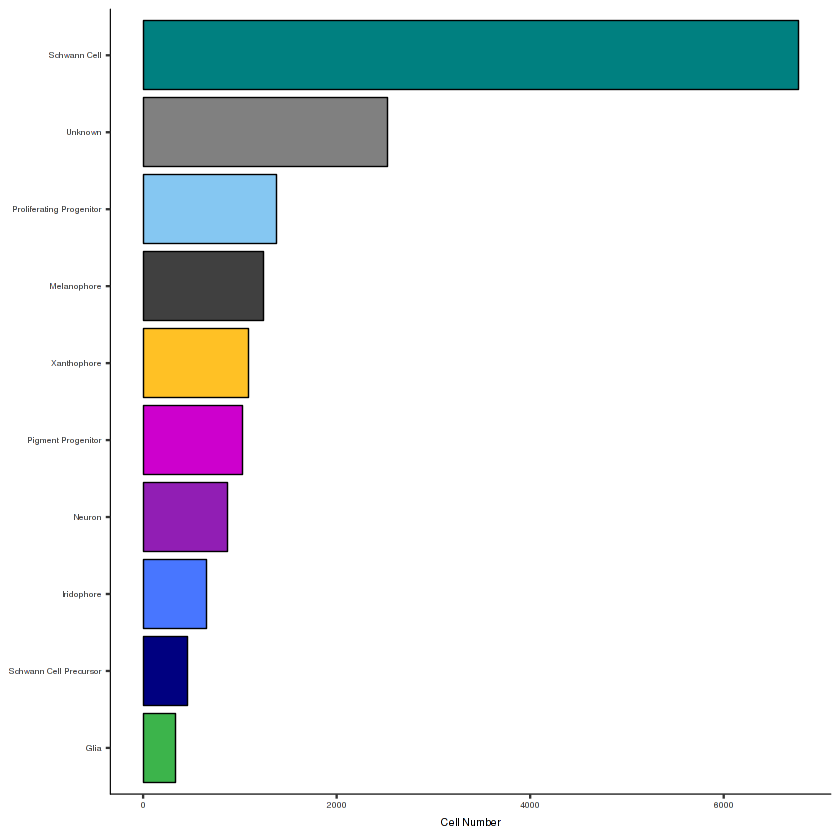

In [84]:
ggplot(tmp, aes(y = count, x = Cell_type_sub, fill = Cell_type_sub)) +
    geom_bar(stat = "identity", color = "black", size = 0.3) + 
    theme(legend.position = "none",
         text = element_text(size = 6),
         axis.title.y=element_blank()) +
    scale_fill_manual(values = cell.colors.2D) +
    xlab("Cell Type") +
    ylab("Cell Number") +
    coord_flip() +
    monocle:::monocle_theme_opts() + 
    ggsave("Plots/euth_hypo_NC-umap_cell-count_barplot_Fig1E.pdf", width = 1.8, height = 2, dpi = 500)


In [28]:
# make barplot for poster sizing
pdf("Plots/euth_hypo_NC-umap_cell-count_barplot_poster.pdf", width = 3.5, height = 3.5)
ggplot(tmp, aes(y = count, x = Cell_type_sub, fill = Cell_type_sub)) +
    geom_bar(stat = "identity", color = "black", size = 0.3) + 
    theme_classic(base_size = 12) +
    scale_fill_manual(values = cell.colors) +
    theme(legend.position = "none", axis.title.y=element_blank()) +
    xlab("Cell Number") +
    coord_flip() +
    monocle:::monocle_theme_opts()
dev.off()

png 
  2

In [85]:
# set order of cell types to match above plot
pdat.tmp <- pData(NC_cds)
pdat.tmp$Cell_type_sub <- factor(pdat.tmp$Cell_type_sub, levels = rev(tmp$Cell_type_sub))

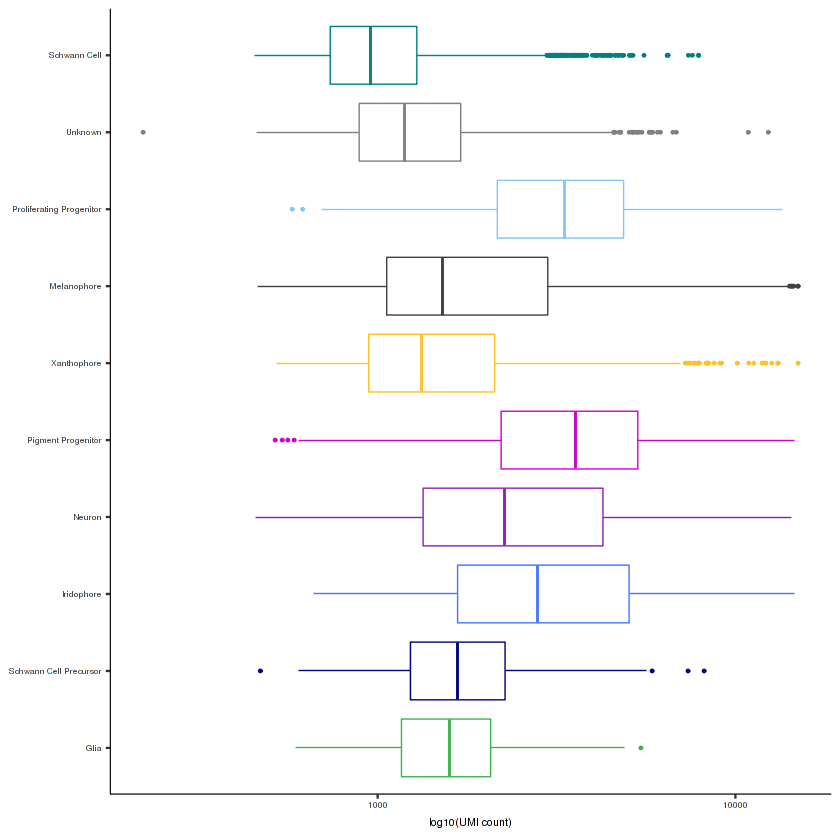

In [113]:
ggplot(pdat.tmp, aes(x = Cell_type_sub, y = total_umis, color = Cell_type_sub)) + 
geom_boxplot(size = 0.3, outlier.size = 0.3) + 
theme(legend.position = "none",
        text = element_text(size=6),
         axis.title.y=element_blank()) +
scale_color_manual(values = cell.colors.2D) +
ylab("log10(UMI count)") +
coord_flip() +
monocle:::monocle_theme_opts() +
scale_y_log10() +
 ggsave("Plots/euth_hypo_all-samples_zg11_aggr_umi-boxplot_Fig1G.pdf", width = 2, height = 2, dpi = 500)

In [ ]:
#saveRDS(NC_cds, file = "R_objects/euth_hypo_all-samples_NC_cds.rds")

### Run MNN batch correction

In [ ]:
library(scran)

In [35]:
preprocessCDS_mnnBatchCorrection <- function (cds, method = c("PCA", "none"), use_tf_idf = FALSE, 
                                              num_dim = 50, norm_method = c("log", "vstExprs", "none"), 
                                              mnnCorrect = FALSE, batch_id = NULL,
                                              pseudo_expr = 1, relative_expr = TRUE, 
                                              scaling = TRUE, verbose = FALSE, ...) 
{
    extra_arguments <- list(...)
    set.seed(2016)
    
    FM <- normalize_expr_data(cds, norm_method, pseudo_expr, 
        relative_expr)
    
    if (nrow(FM) == 0) {
        stop("Error: all rows have standard deviation zero")
    }
    
    fm_rowsums = Matrix::rowSums(FM)
    FM <- FM[is.finite(fm_rowsums) & fm_rowsums != 0, ]
    cds@auxOrderingData$normalize_expr_data <- FM
         
    if (method == "PCA") {
        if (verbose) 
            message("Remove noise by PCA ...")
        irlba_res <- sparse_prcomp_irlba(t(FM), n = min(num_dim, 
            min(dim(FM)) - 1), center = scaling, scale. = scaling)
        irlba_pca_res <- irlba_res$x
        
        row.names(irlba_pca_res) <- colnames(FM)
        
          ### split PCA matrix by batch
        
         if(mnnCorrect == TRUE){
             
        batch_cells_list <- list()
        batches <- unique(pData(cds)$sample)
   
        for(batch in batches){
            
            batch_cells_list[[batch]] <- row.names(pData(cds)[pData(cds)$sample == batch,])

            
        }
             
             PCA_batch1 <- irlba_pca_res[batch_cells_list[[1]],]
             PCA_batch2 <- irlba_pca_res[batch_cells_list[[2]],]
             PCA_batch3 <- irlba_pca_res[batch_cells_list[[3]],]
             PCA_batch4 <- irlba_pca_res[batch_cells_list[[4]],]
             PCA_batch5 <- irlba_pca_res[batch_cells_list[[5]],]
             PCA_batch6 <- irlba_pca_res[batch_cells_list[[6]],]
             PCA_batch7 <- irlba_pca_res[batch_cells_list[[7]],]
             PCA_batch8 <- irlba_pca_res[batch_cells_list[[8]],]
             PCA_batch9 <- irlba_pca_res[batch_cells_list[[9]],]
             PCA_batch10 <- irlba_pca_res[batch_cells_list[[10]],]
             PCA_batch11 <- irlba_pca_res[batch_cells_list[[11]],]
             PCA_batch12 <- irlba_pca_res[batch_cells_list[[12]],]
             PCA_batch13 <- irlba_pca_res[batch_cells_list[[13]],]

             corrected_PCA <- mnnCorrect(t(PCA_batch1),t(PCA_batch2), t(PCA_batch3), t(PCA_batch4),
                                        t(PCA_batch5), t(PCA_batch6), t(PCA_batch7), t(PCA_batch8),
                                        t(PCA_batch9), t(PCA_batch10), t(PCA_batch11), t(PCA_batch12),
                                        t(PCA_batch13))
             corrected_PCA <- t(do.call("cbind", corrected_PCA[["corrected"]]))
             row.names(corrected_PCA) <- c(row.names(PCA_batch1),row.names(PCA_batch2), row.names(PCA_batch3), row.names(PCA_batch4),
                                        row.names(PCA_batch5), row.names(PCA_batch6), row.names(PCA_batch7), row.names(PCA_batch8),
                                        row.names(PCA_batch9), row.names(PCA_batch10), row.names(PCA_batch11), row.names(PCA_batch12),
                                        row.names(PCA_batch13))
             corrected_PCA <- corrected_PCA[colnames(cds),]
    }
      
    }
    else if (method == "none") {
        corrected_PCA <- FM
    }
    else {
        stop("unknown preprocessing method, stop!")
    }
    cds@normalized_data_projection <- corrected_PCA
    cds
}

In [37]:
length(unique(pData(NC_cds)$sample))

[1] 13

In [38]:
corr_NC_cds <- preprocessCDS_mnnBatchCorrection(NC_cds, method = 'PCA', 
                                                num_dim = 30, norm_method = 'log', 
                                                mnnCorrect = TRUE, verbose = T)

Remove noise by PCA ...


In [39]:
head(pData(corr_NC_cds))

cell                                         
AAACCTGTCCAGTATG-1_aggregated_samples_pigment AAACCTGTCCAGTATG-1_aggregated_samples_pigment
AAACGGGAGTGAACAT-1_aggregated_samples_pigment AAACGGGAGTGAACAT-1_aggregated_samples_pigment
AAACGGGCACTTACGA-1_aggregated_samples_pigment AAACGGGCACTTACGA-1_aggregated_samples_pigment
AAACGGGCATCCGTGG-1_aggregated_samples_pigment AAACGGGCATCCGTGG-1_aggregated_samples_pigment
AAACGGGGTAGGCATG-1_aggregated_samples_pigment AAACGGGGTAGGCATG-1_aggregated_samples_pigment
AAAGATGCACCACCAG-1_aggregated_samples_pigment AAAGATGCACCACCAG-1_aggregated_samples_pigment
                                              total_umis sample   TSNE.1     
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 1871       euth_juv  0.05580176
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 1816       euth_juv -4.41935733
AAACGGGCACTTACGA-1_aggregated_samples_pigment 1795       euth_juv -3.60241005
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 1932       euth_juv -2.19400028
AAACGGGGTAGGCATG-1_aggregated_samples_pigment  932       euth_juv -3.84655397
AAAGATGCACCACCAG-1_aggregated_samples_pigment 1228       euth_juv -3.95498689
                                              TSNE.2     Size_Factor condition
AAACCTGTCCAGTATG-1_aggregated_samples_pigment  -7.909065 1.2452660   euth     
AAACGGGAGTGAACAT-1_aggregated_samples_pigment -38.150876 1.2086601   euth     
AAACGGGCACTTACGA-1_aggregated_samples_pigment  -7.720802 1.1946833   euth     
AAACGGGCATCCGTGG-1_aggregated_samples_pigment  -9.502526 1.2858652   euth     
AAACGGGGTAGGCATG-1_aggregated_samples_pigment  -7.265528 0.6203035   euth     
AAAGATGCACCACCAG-1_aggregated_samples_pigment  -8.148889 0.8173098   euth     
                                              num_genes_expressed tsne_1      
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 856                 -11.61818851
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 952                  -0.02569724
AAACGGGCACTTACGA-1_aggregated_samples_pigment 932                 -14.72032980
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 929                 -10.34764926
AAACGGGGTAGGCATG-1_aggregated_samples_pigment 596                 -13.50423409
AAAGATGCACCACCAG-1_aggregated_samples_pigment 722                 -12.69432238
                                              tsne_2    Cluster peaks halo
AAACCTGTCCAGTATG-1_aggregated_samples_pigment  3.930498 14      FALSE TRUE
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 43.828776 1       FALSE TRUE
AAACGGGCACTTACGA-1_aggregated_samples_pigment  7.265939 14      FALSE TRUE
AAACGGGCATCCGTGG-1_aggregated_samples_pigment  5.885679 14      FALSE TRUE
AAACGGGGTAGGCATG-1_aggregated_samples_pigment  6.213567 14      FALSE TRUE
AAAGATGCACCACCAG-1_aggregated_samples_pigment  6.968753 14      FALSE TRUE
                                              delta       rho      Cell_type   
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 0.005269650 165.4461 Glia        
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 0.009346752 250.8803 Schwann Cell
AAACGGGCACTTACGA-1_aggregated_samples_pigment 0.008977446 131.2548 Glia        
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 0.002068659 110.9793 Glia        
AAACGGGGTAGGCATG-1_aggregated_samples_pigment 0.005652243 151.0748 Glia        
AAAGATGCACCACCAG-1_aggregated_samples_pigment 0.010874506 127.7879 Glia        
                                              umap_1   umap_2   
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 1.380155 0.7742559
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 2.103115 1.4577971
AAACGGGCACTTACGA-1_aggregated_samples_pigment 1.420424 0.7723179
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 1.451319 0.8510199
AAACGGGGTAGGCATG-1_aggregated_samples_pigment 1.416179 0.7901413
AAAGATGCACCACCAG-1_aggregated_samples_pigment 1.419930 0.8517757
                                              louvain_component Cell_type_sub
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 1                 Other Glia   
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 1       

In [40]:
corr_NC_cds <- reduceDimension(corr_NC_cds, 
                          max_components = 2,
                          nn=3, 
                          louvain_qval=0.05,
                          k=5, 
                          n_neighbors=30L, 
                          min_dist=0.5, 
                          metric="cosine", 
                          reduction_method = 'UMAP',
                          norm_method = 'log', 
                          verbose = T)

Retrieving normalized and PCA (LSI) reduced data ...
Running Uniform Manifold Approximation and Projection


In [41]:
# use for umap 2D
pData(corr_NC_cds)$umap_1 = reducedDimS(corr_NC_cds)[1,]
pData(corr_NC_cds)$umap_2 = reducedDimS(corr_NC_cds)[2,]

In [42]:
head(pData(corr_NC_cds))

cell                                         
AAACCTGTCCAGTATG-1_aggregated_samples_pigment AAACCTGTCCAGTATG-1_aggregated_samples_pigment
AAACGGGAGTGAACAT-1_aggregated_samples_pigment AAACGGGAGTGAACAT-1_aggregated_samples_pigment
AAACGGGCACTTACGA-1_aggregated_samples_pigment AAACGGGCACTTACGA-1_aggregated_samples_pigment
AAACGGGCATCCGTGG-1_aggregated_samples_pigment AAACGGGCATCCGTGG-1_aggregated_samples_pigment
AAACGGGGTAGGCATG-1_aggregated_samples_pigment AAACGGGGTAGGCATG-1_aggregated_samples_pigment
AAAGATGCACCACCAG-1_aggregated_samples_pigment AAAGATGCACCACCAG-1_aggregated_samples_pigment
                                              total_umis sample   TSNE.1     
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 1871       euth_juv  0.05580176
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 1816       euth_juv -4.41935733
AAACGGGCACTTACGA-1_aggregated_samples_pigment 1795       euth_juv -3.60241005
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 1932       euth_juv -2.19400028
AAACGGGGTAGGCATG-1_aggregated_samples_pigment  932       euth_juv -3.84655397
AAAGATGCACCACCAG-1_aggregated_samples_pigment 1228       euth_juv -3.95498689
                                              TSNE.2     Size_Factor condition
AAACCTGTCCAGTATG-1_aggregated_samples_pigment  -7.909065 1.2452660   euth     
AAACGGGAGTGAACAT-1_aggregated_samples_pigment -38.150876 1.2086601   euth     
AAACGGGCACTTACGA-1_aggregated_samples_pigment  -7.720802 1.1946833   euth     
AAACGGGCATCCGTGG-1_aggregated_samples_pigment  -9.502526 1.2858652   euth     
AAACGGGGTAGGCATG-1_aggregated_samples_pigment  -7.265528 0.6203035   euth     
AAAGATGCACCACCAG-1_aggregated_samples_pigment  -8.148889 0.8173098   euth     
                                              num_genes_expressed tsne_1      
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 856                 -11.61818851
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 952                  -0.02569724
AAACGGGCACTTACGA-1_aggregated_samples_pigment 932                 -14.72032980
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 929                 -10.34764926
AAACGGGGTAGGCATG-1_aggregated_samples_pigment 596                 -13.50423409
AAAGATGCACCACCAG-1_aggregated_samples_pigment 722                 -12.69432238
                                              tsne_2    Cluster peaks halo
AAACCTGTCCAGTATG-1_aggregated_samples_pigment  3.930498 14      FALSE TRUE
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 43.828776 1       FALSE TRUE
AAACGGGCACTTACGA-1_aggregated_samples_pigment  7.265939 14      FALSE TRUE
AAACGGGCATCCGTGG-1_aggregated_samples_pigment  5.885679 14      FALSE TRUE
AAACGGGGTAGGCATG-1_aggregated_samples_pigment  6.213567 14      FALSE TRUE
AAAGATGCACCACCAG-1_aggregated_samples_pigment  6.968753 14      FALSE TRUE
                                              delta       rho      Cell_type   
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 0.005269650 165.4461 Glia        
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 0.009346752 250.8803 Schwann Cell
AAACGGGCACTTACGA-1_aggregated_samples_pigment 0.008977446 131.2548 Glia        
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 0.002068659 110.9793 Glia        
AAACGGGGTAGGCATG-1_aggregated_samples_pigment 0.005652243 151.0748 Glia        
AAAGATGCACCACCAG-1_aggregated_samples_pigment 0.010874506 127.7879 Glia        
                                              umap_1    umap_2   
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 0.4998343 1.0577234
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 0.1057727 0.6895880
AAACGGGCACTTACGA-1_aggregated_samples_pigment 0.4585031 1.0420997
AAACGGGCATCCGTGG-1_aggregated_samples_pigment 0.4226051 0.9829628
AAACGGGGTAGGCATG-1_aggregated_samples_pigment 0.4658232 1.0286575
AAAGATGCACCACCAG-1_aggregated_samples_pigment 0.4451231 0.9980587
                                              louvain_component Cell_type_sub
AAACCTGTCCAGTATG-1_aggregated_samples_pigment 1                 Other Glia   
AAACGGGAGTGAACAT-1_aggregated_samples_pigment 1

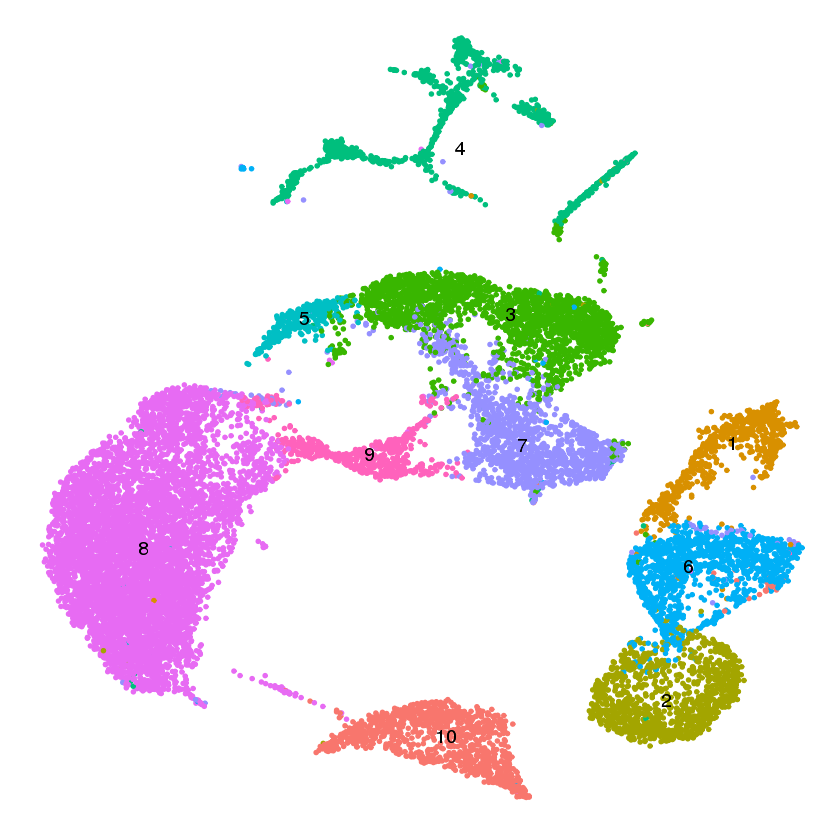

In [43]:
plot_cell_clusters(corr_NC_cds, color_by = "Cell_type_sub", cell_size = 0.5, show_group_id = TRUE) +
    scale_fill_manual(values = cell.colors) +
    theme_void() +
    theme(legend.position = "none") 
    #ggsave("Plots/euth_hypo_NC-cells_umap2D_clusters_batch-corrected.png", units = "in", width = 6, height = 6, dpi = 400)

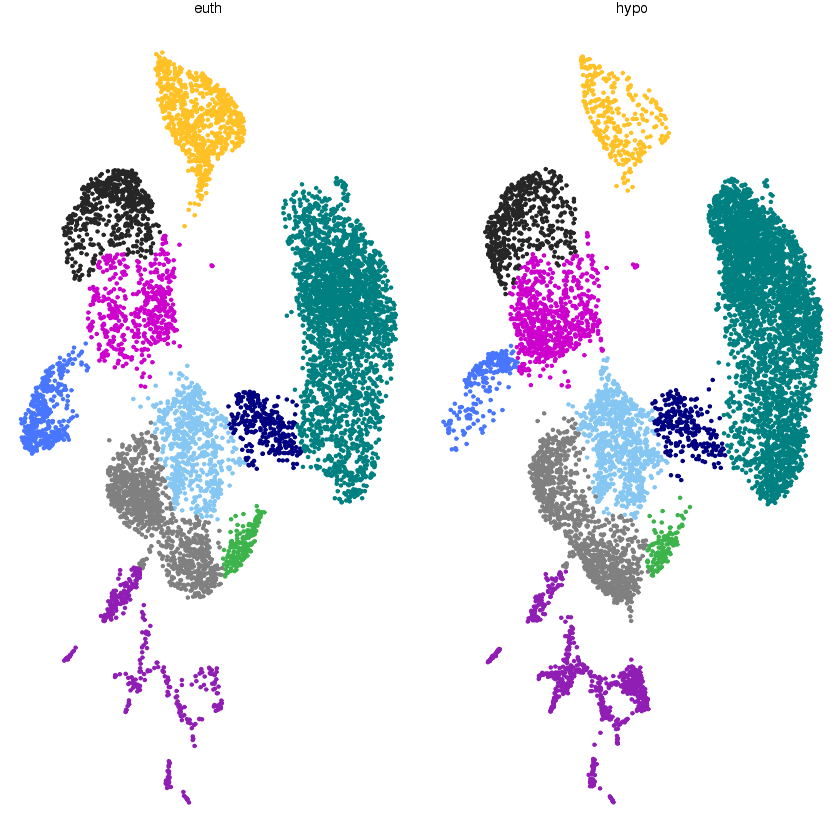

In [8]:
ggplot(pData(NC_cds), aes(x = umap_1, y = umap_2, color = Cell_type_sub)) +
   geom_point(size = 0.2) +
    monocle:::monocle_theme_opts() +
    theme_void() +
    scale_colour_manual(values = cell.colors) +
    facet_wrap(~condition) +
    theme(legend.position = "none") +
    ggsave("Plots/euth_hypo_NC_2D-umap_facet-condition.png.png",
           device = "png", width = 10, height = 5, dpi = 600)

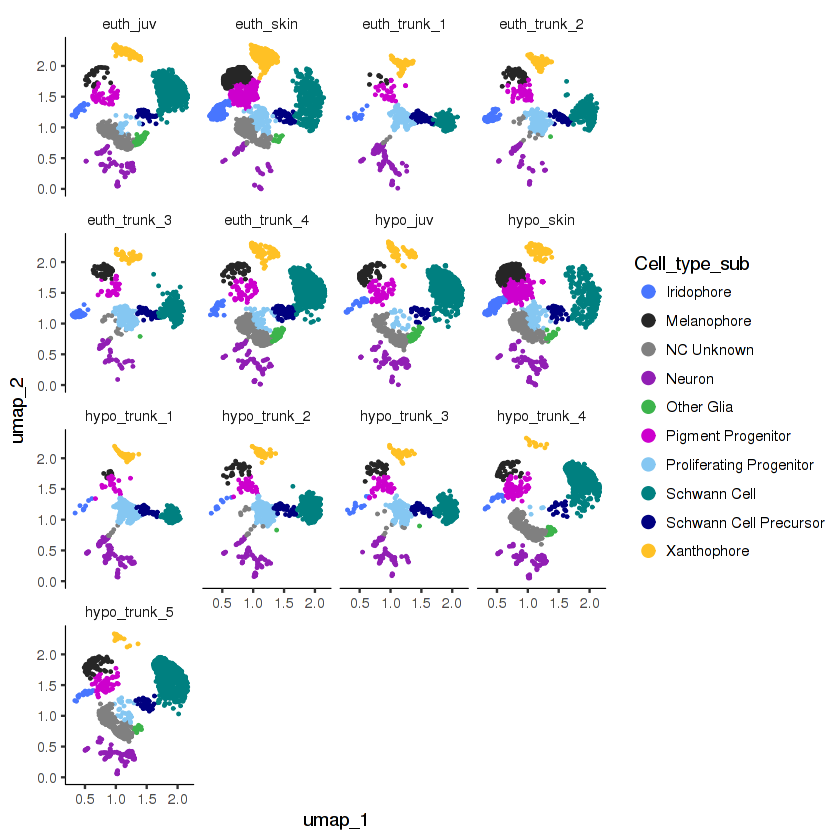

In [81]:
ggplot(pData(NC_cds), aes(x = umap_1, y = umap_2, color = Cell_type_sub)) +
   geom_point(size = 0.3) +
    monocle:::monocle_theme_opts() +
    facet_wrap(~sample) +
    scale_colour_manual(values = cell.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    ggsave("Plots/euth_hypo_all-samples_NC_sample-facet_no-batch-corr.png",
           device = "png", width = 12, height = 10, dpi = 600)

In [50]:
corr_NC_cds <- clusterCells(corr_NC_cds, verbose = T, method = "louvain", res = 1e-3, k = 50)

Warning message in if (cell_names != row.names(pd)) stop("phenotype and row name from the data doesn't match"):
“the condition has length > 1 and only the first element will be used”Run kNN based graph clustering starts:
  -Input data of 16150 rows and 2 columns
  -k is set to 50


  Finding nearest neighbors...DONE ~ 0.241 s
  Compute jaccard coefficient between nearest-neighbor sets ...DONE ~ 0.033 s
  Build undirected graph from the weighted links ...DONE ~ 0.331 s
  Run louvain clustering on the graph ...
Running louvain iteration  1 ...


Current iteration is 1; current resolution is 0.001; Modularity is 0.835688815305492; Number of clusters are 10


Running louvain iteration  2 ...


Current iteration is 2; current resolution is 0.001; Modularity is 0.856946264391722; Number of clusters are 12


Running louvain iteration  3 ...


Current iteration is 3; current resolution is 0.001; Modularity is 0.880330103905869; Number of clusters are 12


Running louvain iteration  4 ...


Current iteration is 4; current resolution is 0.001; Modularity is 0.855408889424147; Number of clusters are 11


Running louvain iteration  5 ...


Current iteration is 5; current resolution is 0.001; Modularity is 0.855813829971164; Number of clusters are 11
Maximal modularity is 0.880330103905869; corresponding resolution is 0.001

Run kNN based graph clustering DONE, totally takes 36.7952928543091 s.


  -Number of clusters: 12 


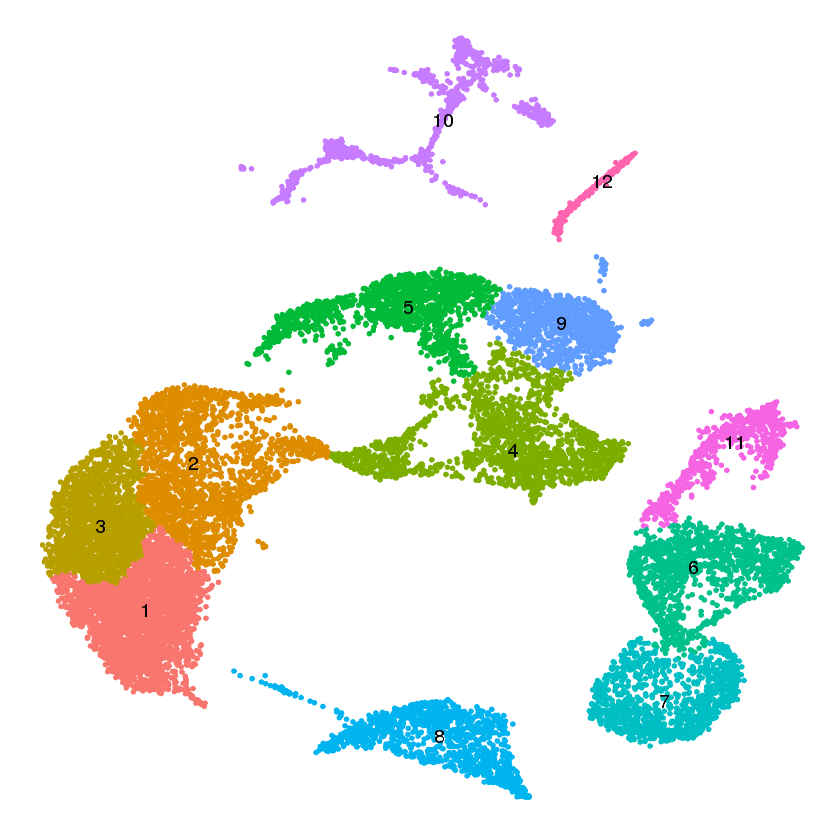

In [51]:
plot_cell_clusters(corr_NC_cds, color_by = "Cluster", cell_size = 0.5, show_group_id = TRUE) +
    theme_void() +
    theme(legend.position = "none") 
    #ggsave("Plots/euth_hypo_NC-cells_umap2D_clusters_batch-corrected.png", units = "in", width = 6, height = 6, dpi = 400)

In [44]:
#saveRDS(corr_NC_cds, "R_objects/euth_hypo_NC_2D-UMAP_cds_batchCorr.rds")

## Look at expression differences between sub-clusters

In [5]:
source("monocle_help_functions.R")

In [106]:
fData(NC_cds)[grep("h2af", fData(NC_cds)$gene_short_name),]

id                 gene_short_name num_cells_expressed
ENSDARG00000068820 ENSDARG00000068820 h2afva          2405               
ENSDARG00000029406 ENSDARG00000029406 h2afx            991               
ENSDARG00000087897 ENSDARG00000087897 h2afy2          5001               
ENSDARG00000099329 ENSDARG00000099329 h2afy            398               
ENSDARG00000068995 ENSDARG00000068995 h2afx1          7327               
ENSDARG00000116491 ENSDARG00000116491 h2afvb          4768               
ENSDARG00000098739 ENSDARG00000098739 h2af1al            8

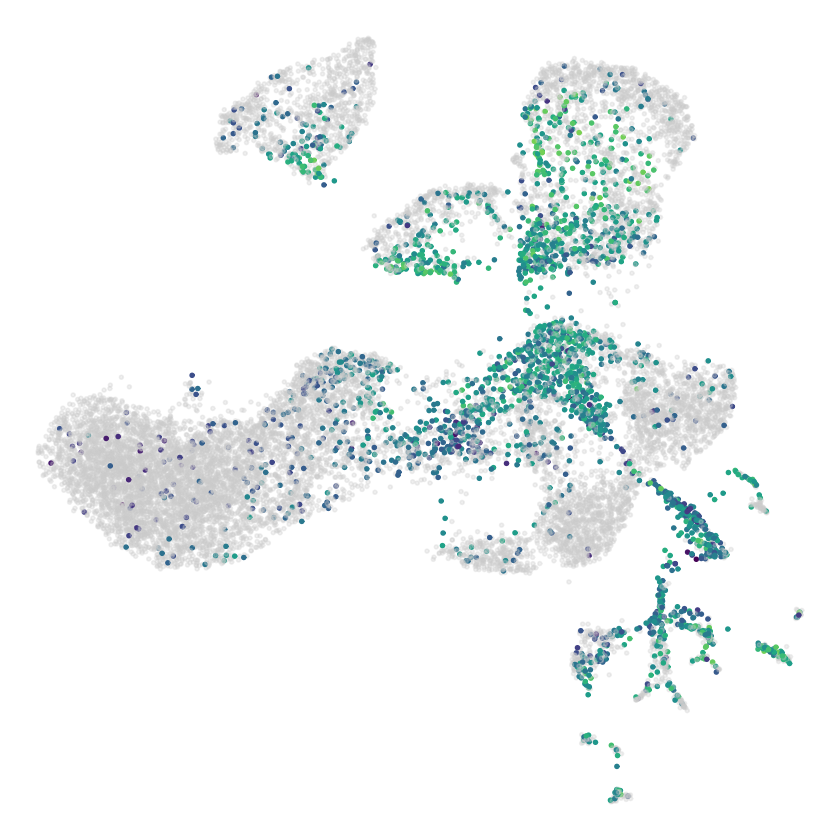

In [107]:
#png("Plots/euth_hypo_NC_sox10-expr.png", units = "in", height = 5, width = 6, res = 500)
plot_grey_marker_umap(NC_cds, "h2afva") #+
    #facet_wrap(~condition)
#dev.off()

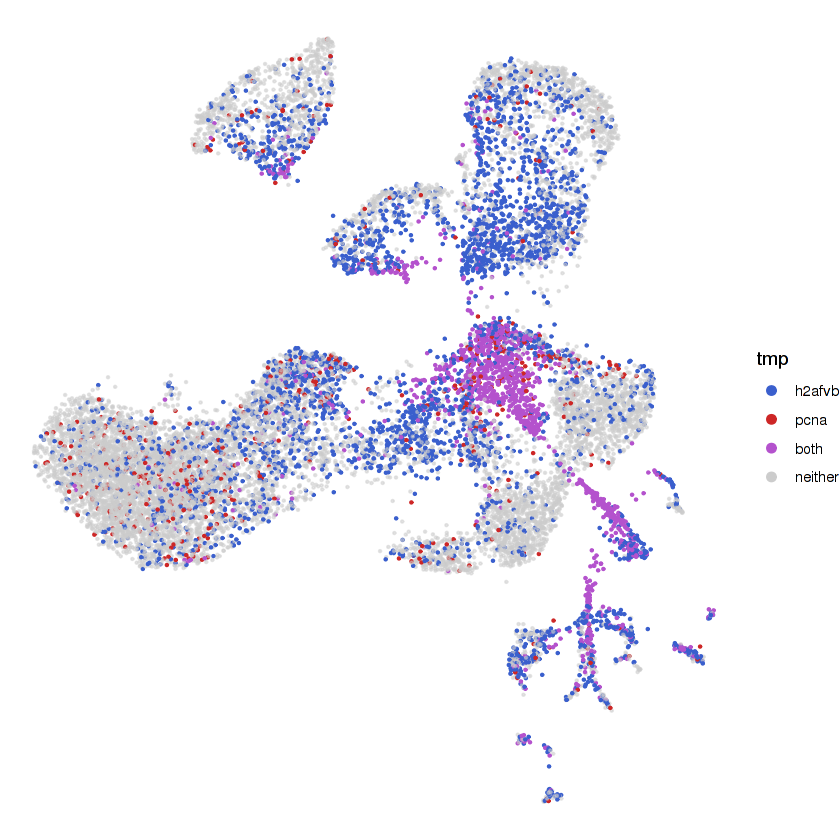

In [90]:
plot.two.genes(NC_cds, "h2afvb", "pcna")

In [94]:
pdf("Plots/euth_hypo_NC_h2afvb-pnca_dual-expr.pdf", width = 7, height =6)
plot.two.genes(NC_cds, "h2afvb", "pcna")
dev.off()

png 
  2

In [45]:
# generate marker graphs for poster
png("Plots/euth_hypo_NC-umap_2D_aox5_marker.png", units = "in", width = 4, height = 4, res = 400)
plot_grey_marker_umap(NC_cds, "aox5") 
dev.off()

png("Plots/euth_hypo_NC-umap_2D_pnp4a_marker.png", units = "in", width = 4, height = 4, res = 400)
plot_grey_marker_umap(NC_cds, "pnp4a") 
dev.off()

png("Plots/euth_hypo_NC-umap_2D_tyrp1b_marker.png", units = "in", width = 4, height = 4, res = 400)
plot_grey_marker_umap(NC_cds, "tyrp1b") 
dev.off()

In [ ]:
## this function generates an array of tSNE plots with annotated marker expression
## will need to change saving settings for each gene set
save_marker_tSNE <- function(cds, marker_genes){
    
    plot.list <- list()
    
    for(marker in marker_genes){
     
        cds_subset <- cds[fData(cds)$gene_short_name == marker,]
        marker_expr <- Matrix::t(exprs(cds_subset))/pData(cds_subset)$Size_Factor
        
        pData(cds_subset)$marker <- as.numeric(marker_expr[,1])
        
        #plot_title <- paste0("Plots/hypoTH_comb_tSNE_",marker,".png")
        color_str <- paste0("log10(",marker," + 0.1)")
        
        plot.list[[marker]] <- plot_cell_clusters(cds_subset, color_by = "log10(marker + 0.1)", cell_size = .75) +
        scale_color_viridis(option = "magma", name = color_str) +
        ggtitle(marker) + 
        theme(plot.title = element_text(hjust = 0.5), legend.position = "right", legend.title = element_text(size = 8), 
              legend.text = element_text(size = 8), legend.key.size = unit(.01, "npc"), 
              legend.key.height = unit(.02, "npc"))
        
    }
    png("Plots/general_all-cell_marker_array.png", units = "in", width = 14, height = 12, res = 300)
    do.call("grid.arrange", c(plot.list, ncol=3))
    dev.off()
}

In [31]:
head(NC_cds@assayData$exprs)

   [[ suppressing 16150 column names ‘AAACCTGTCCAGTATG-1_aggregated_samples_pigment’, ‘AAACGGGAGTGAACAT-1_aggregated_samples_pigment’, ‘AAACGGGCACTTACGA-1_aggregated_samples_pigment’ ... ]]


6 x 16150 sparse Matrix of class "dgTMatrix"
                                                                              
ENSDARG00000104632 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSDARG00000100660 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSDARG00000098417 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSDARG00000100422 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSDARG00000102128 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSDARG00000103095 . . . . . . . . . . . . . . . . . 1 . 1 . . . . . . . 2 . .
                                                                              
ENSDARG00000104632 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSDARG00000100660 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSDARG00000098417 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSDARG00000100422 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSDARG

In [ ]:
# plot genes to mark relevant populations
save_marker_tSNE(all_cds, c("mcherry", "sox10", "mbpa", "pnp4a", "tyrp1b", "aox5", "mitfa",
                            "olig2", "tfec"))

## Plot specifcity of markers for individual clusters (violin plot)

In [49]:
subset_cds <- NC_cds[fData(NC_cds)$gene_short_name == "pmela",]

In [50]:
pmela <- Matrix::t(exprs(subset_cds))/pData(subset_cds)$Size_Factor

In [51]:
pData(subset_cds)$pmela <- as.numeric(pmela[,1])

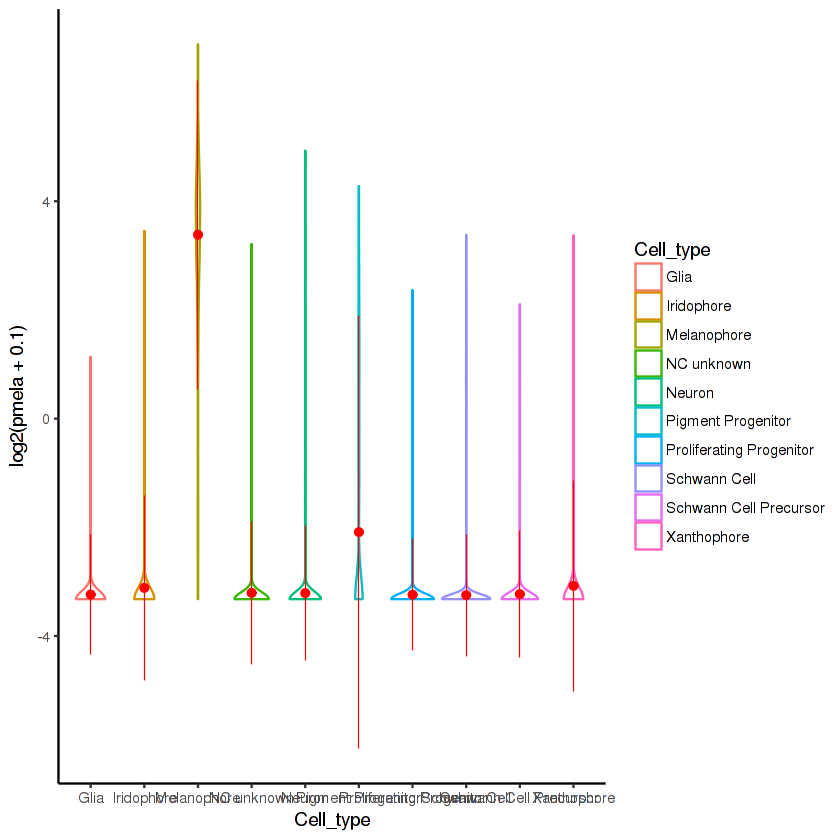

In [52]:
ggplot(pData(subset_cds), aes(x = Cell_type, y = log2(pmela + 0.1), color = Cell_type)) + 
    geom_violin() + stat_summary(fun.data=mean_sdl, geom="pointrange", color="red", size=.25) + 
    theme_classic() #+
    #ggsave("Plots/NC-sub_mitfa-expr_violin.pdf", width = 10, height = 6)

## Look at DEGs by cell type based on TH-status

In [ ]:
# filter for expressed genes
NC_expressed_genes <-  row.names(subset(fData(NC_cds), num_cells_expressed >= 10))
NC_filtered <- NC_cds[NC_expressed_genes,]

In [ ]:
# deg_res <- differentialGeneTest(NC_filtered, fullModelFormulaStr = "~Cell_type_sub*condition",
#                                 reducedModelFormulaStr = "~Cell_type_sub", cores = 10)

In [ ]:
deg_res <- readRDS("R_objects/euth_hypo_NC_celltype-TH_DEG_res.rds")

In [ ]:
deg_filt <- deg_res %>% filter(qval < 0.01) %>% select(id)

In [ ]:
head(deg_filt)

In [ ]:
get.norm.expr.matrix = function(cds) {
    mat = as(exprs(cds), "dgCMatrix")
    mat@x = mat@x / rep.int(pData(cds)$Size_Factor, diff(mat@p))
    return(mat)
}

In [ ]:
NC.norm.expr <- get.norm.expr.matrix(NC_cds)

In [ ]:
deg_mat <- as.matrix(exprs(NC_cds)[deg_filt[,1],])

In [ ]:
dim(deg_mat)

In [ ]:
# randomly sample cells for ease of plotting
deg_mat <- deg_mat[,sample(colnames(deg_mat), 5000)]

In [ ]:
# order cells by by cell type and rearrange matrix
tmp <- pData(NC_cds)[colnames(deg_mat),]
tmp <- tmp %>% arrange(Cell_type_sub)
deg_mat <- deg_mat[,as.character(tmp[,1])]

In [ ]:
deg_mat = log2(deg_mat+1)
deg_mat = t(scale(t(deg_mat)))
deg_mat = ifelse(deg_mat < -2.0, -2.0, deg_mat)
deg_mat = ifelse(deg_mat > 2.0, 2.0, deg_mat)

In [ ]:
row.order <- hclust(dist(deg_mat))$order

In [ ]:
deg_new <- deg_mat[row.order,]

In [ ]:
head(deg_mat)

In [ ]:
head(deg_new)

In [ ]:
deg_melt <- melt(as.matrix(deg_new))
names(deg_melt)[c(1:2)] <- c("gene_id", "cell")

In [ ]:
head(deg_melt)

In [ ]:
png("Plots/euth_hypo_NC_TH-cellType_DEGs_hm.png")
ggplot(data = deg_melt, aes(x = gene_id, y = cell, fill = value)) +
    geom_raster() +
    xlab("Gene") +
    scale_fill_gradient2(low = "#FF00FF",
      mid = "#000000",
      high = "#FFFF00",
      name= "Expression") +
    theme(axis.text.x = element_blank(),
          axis.text.y = element_blank())
dev.off()

In [ ]:
tail(deg_melt)

## check enriched DEGs for different clusters

In [24]:
NC_cds@rge_method <- "NA"

In [ ]:
plot_marker_tSNE(NC_cds)

In [ ]:
# filter for expressed genes
NC_expressed_genes <-  row.names(subset(fData(NC_cds), num_cells_expressed >= 10))
NC_filtered <- NC_cds[NC_expressed_genes,]

In [146]:
temp_df <- two.set.differential.gene.test(NC_cds, 
                               pData(NC_cds)$Cluster == 20, 
                                pData(NC_cds)$Cluster != 20,
                                formal = F)

# of cells in set 1: 85
# of cells in set 2: 16365


In [147]:
# check expr
temp_df %>% filter(higher.cluster == "Set 1") %>% head(20)

ERROR: Error in filter_impl(.data, quo): Evaluation error: object 'higher.cluster' not found.


In [ ]:
temp_df$higher.cluster = rep("unknown", nrow(temp_df))
temp_df$higher.cluster <- with(temp_df, ifelse(higher.expr == "Set 1", "Cluster 8", higher.cluster))
temp_df$higher.cluster <- with(temp_df, ifelse(higher.expr == "Set 2", "Cluster 16", higher.cluster))

In [ ]:
temp_df$Cell_type <- rep("Xanthophore", nrow(temp_df))

In [ ]:
# annotate list with full gene names
genes <- read.csv("zfish_full_gene_list.csv", colClasses = "character") %>% select(symbol = Marker.Symbol, Marker.Name)
head(genes)

In [ ]:
temp_df$symbol <- as.character(temp_df$symbol)

In [ ]:
#annotate genes with full gene names
temp_df <- left_join(temp_df, genes, by = "symbol") 

In [ ]:
temp_df <- temp_df %>% select(Cell_type, gene, symbol, full_name = Marker.Name, higher.cluster,
                              set.1.tpm, set.2.tpm, log2.ratio, p.val, q.val, precision, recall, f.score)

In [ ]:
temp_df %>% filter(higher.cluster == "Cluster 8") %>% arrange(q.val) %>% head()

In [ ]:
temp_df %>% filter(q.val < 0.1) %>% arrange(higher.cluster) %>% write.csv("xan_two-clust_DEA.csv")

In [ ]:
temp_df %>% filter(higher.expr == "Set 1") %>% write.csv("filename")

## generate DEGs for all clusters compared to each other

In [ ]:
#DEG.results <- readRDS("R_objects/euth_hypo_NC-deriv_cluster_DEG_results.rds") # by Cluster
DEG.results <- readRDS("R_objects/euth_hypo_NC-deriv_celltype_DEG_results.rds") # by cell_type_sub

In [ ]:
cluster_indices =
      sort(as.integer(unique(pData(NC_cds)$Cluster)))

cluster_indices

In [ ]:
# to sort by cell type:
cluster_indices =
      sort(as.character(unique(pData(NC_cds)$Cell_type_sub)))

cluster_indices

In [ ]:
# # Instead of re-running below you can use the above cell...
# DEG.results = lapply(cluster_indices,
#     function(this.cluster) {
#   message("Finding markers for cluster ", this.cluster)
#     cbind(
#         two.set.differential.gene.test(
#             NC_cds,
#             pData(NC_cds)$Cell_type_sub == this.cluster,
#             pData(NC_cds)$Cell_type_sub != this.cluster,
#             formal = T,
#             cores = 10),
#         data.frame(cell_type_sub = this.cluster))
# })
# saveRDS(DEG.results, file = "R_objects/euth_hypo_NC-deriv_celltype_DEG_results.rds")
# #saveRDS(DEG.results, file = "R_objects/euth_hypo_NC-deriv_cluster_DEG_results.rds")

In [ ]:
#saveRDS(DEG.results, file = "R_objects/euth_hypo_NC-deriv_cluster_DEG_results.rds")
#saveRDS(DEG.results, file = "R_objects/euth_hypo_NC-deriv_celltype_DEG_results.rds")

In [ ]:
# this function combines DEG results from each cluster against all others 
cluster.markers =
    do.call(rbind, DEG.results) %>%
        filter(higher.expr == "Set 1") %>%
  select(
      Cell_type = cell_type_sub, gene, symbol,
      cluster.n.umi = set.1.n.umi,
      other.n.umi = set.2.n.umi,
      cluster.tpm = set.1.tpm,
      other.tpm = set.2.tpm,
      log2.ratio, precision, recall, f.score, p.val, q.val) %>%
  arrange(q.val)
# was Cluster = cluster

In [ ]:
head(cluster.markers)

In [ ]:
# annotate list with full gene names
genes <- read.csv("zfish_full_gene_list.csv", colClasses = "character") %>% select(symbol = Marker.Symbol, Marker.Name)
tail(genes)

In [ ]:
cluster.markers$symbol <- as.character(cluster.markers$symbol)

In [ ]:
#annotate genes with full gene names
cluster.markers <- left_join(cluster.markers, genes, by = "symbol") 

In [ ]:
# label clusters with corresponding cell-type (just for cluster DEA)
cluster.markers$Cell_type = rep("unknown", nrow(cluster.markers))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 8, "Xanthophore", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 16, "Xanthophore", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 7, "Melanophore", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 9, "Iridophore", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 5, "Pigment progenitor", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 3, "Schwann Cell Precursor", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 13, "Schwann Cell Precursor", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 2, "Schwann Cell", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 10, "Schwann Cell", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 6, "Proliferating Progenitor", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 1, "Proliferating Progenitor", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 11, "Neurons", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 15, "Neurons", Cell_type))
cluster.markers$Cell_type = with(cluster.markers, ifelse(Cluster == 12, "Other Glia", Cell_type))

In [ ]:
# look at markers for each cluster compared to the rest of the clusters
cluster.markers %>% filter(Cell_type == "Xanthophore") %>% head(40)

In [ ]:
fData(NC_cds)[grep("arl13", fData(NC_cds)$gene_short_name),] %>% filter(num_cells_expressed > 100)

In [ ]:
unique(NC_cds$Cell_type_sub)

In [ ]:
tf_list = as.data.frame(tf_list)

In [ ]:
tf_id = is.element(cluster.markers$symbol, tf_list)

In [ ]:
cluster.markers$TF_identity = rep("unknown", nrow(cluster.markers))

In [ ]:
cluster.markers$symbol <- as.character(cluster.markers$symbol)

In [ ]:
#annotate whether a particular gene is a transcription factor
cluster.markers$TF_identity <- cluster.markers$symbol %in% tf_list$V1

In [ ]:
head(cluster.markers)

In [ ]:
cluster.markers %>% filter(q.val < 0.1) %>% 
    select(Cell_type, gene, symbol, Marker.Name, 
    p.val, q.val, cluster.n.umi, other.n.umi,
    log2.ratio, precision, recall, f.score) %>%
    arrange(Cell_type) %>%
    write.csv(file = "NC-celltype_DEA_update180530.csv")

In [ ]:
# pull out genes that would be good, specific markers by filtering tpms
cluster.markers.umi.filt <- cluster.markers[cluster.markers$cluster.n.umi > cluster.markers$other.n.umi,]

In [ ]:
dim(cluster.markers %>% filter(q.val < 0.05))
dim(cluster.markers.umi.filt)

In [ ]:
cluster.markers.umi.filt %>% filter(q.val < 0.1) %>% 
    select(Cell_type, gene, symbol, Marker.Name, 
    p.val, q.val, cluster.n.umi, other.n.umi,
    log2.ratio, precision, recall, f.score) %>%
    arrange(Cell_type) %>%
    write.csv(file = "NC-celltype_DEA_umi-filt.csv")

### Pull out cell names 

In [ ]:
tmp <- strsplit(as.character(pData(NC_cds)$cell), "_a")

In [ ]:
cells <- as.data.frame(matrix(unlist(tmp), ncol=2, byrow = TRUE))[,1]

In [ ]:
saveRDS(cells, "euth_hypo_NC-cell_barcodes.rds")

## Make large heatmap

In [ ]:
# select DEGs from the cluster-specific DEG test
degs <- cluster.markers %>% filter(q.val < 1e-80) %>% select(gene)

In [ ]:
dim(degs)

In [ ]:
deg_mat <- as.matrix(exprs(NC_cds)[degs[,1],])

In [ ]:
# randomly sample cells for ease of plotting
tmp <- deg_mat[,sample(colnames(deg_mat), 5000)]

In [ ]:
deg_mat <- tmp

In [ ]:
is.matrix(deg_mat)
dim(deg_mat)

In [ ]:
library(pheatmap)

In [ ]:
deg_mat = log2(deg_mat+1)
deg_mat = t(scale(t(deg_mat)))
deg_mat = ifelse(deg_mat < -2.0, -2.0, deg_mat)
deg_mat = ifelse(deg_mat > 2.0, 2.0, deg_mat)

In [ ]:
# make heatmap with ggplot

In [ ]:
df_expression <- read.csv("expression.csv")
df_molten <- melt(df_expression)
ggplot(data = df_molten,
       aes(x = variable, y = MouseID, fill = value)) + 
    geom_raster() +
    xlab("Protein") + 
    scale_fill_distiller(palette = "RdYlBu", trans = "log10") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          axis.text.y = element_blank())

In [ ]:
deg_melt <- melt(deg_mat) %>% select(gene_id = Var1, cell = Var2, expr = value)

In [ ]:
png("Plots/euth_hypo_NC-ggplot_hm.png")
ggplot(data = deg_melt, aes(x = gene_id, y = cell, fill = expr)) +
    geom_raster() +
    xlab("Gene") +
    scale_fill_gradient2(low = "#FF00FF",
      mid = "#000000",
      high = "#FFFF00",
      name= "Expression") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          axis.text.y = element_blank())
dev.off()

In [ ]:
head(deg_melt)

In [ ]:
dat <- df_expression[,2:78]  # numerical columns
rownames(dat) <- df_expression[,1]
row.order <- hclust(dist(dat))$order # clustering
col.order <- hclust(dist(t(dat)))$order
dat_new <- dat[row.order, col.order] # re-order matrix accoring to clustering

df_molten_dat <- melt(as.matrix(dat_new)) # reshape into dataframe
names(df_molten_dat)[c(1:2)] <- c("MouseID", "Protein")

ggplot(data = df_molten_dat,
       aes(x = Protein, y = MouseID, fill = value)) + 
    geom_raster() +
    scale_fill_distiller(palette = "RdYlBu", trans = "log10") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          axis.text.y = element_blank()) + 
    ggtitle("Clustered ggplot heatmap")

In [ ]:
dat <- deg_mat[,2:ncol(deg_mat)] # just numerical cols
rownames(dat) <- rownames(deg_mat) # make genes rownames so they're ignored by clust

In [ ]:
head(dat)

In [ ]:
row.order <- hclust(dist(dat))$order

In [ ]:
col.order <- hclust(dist(t(dat)))$order

In [ ]:
deg_new <- dat[row.order, col.order]

In [ ]:
head(deg_new)

In [ ]:
deg_melt2 <- melt(as.matrix(deg_new))
names(deg_melt2)[c(1:2)] <- c("gene_id", "cell")

In [ ]:
png("Plots/euth_hypo_NC-ggplot_hm.png")
ggplot(data = deg_melt2, aes(x = gene_id, y = cell, fill = value)) +
    geom_raster() +
    xlab("Gene") +
    scale_fill_gradient2(low = "#FF00FF",
      mid = "#000000",
      high = "#FFFF00",
      name= "Expression") +
    theme(axis.text.x = element_blank(),
          axis.text.y = element_blank())
dev.off()

In [ ]:
head(deg_melt2)

In [ ]:
 heatmap <- ggplot(
    data = data.use,
    mapping = aes(x = cell, y = gene, fill = expression)
  ) +
    geom_tile() +
    scale_fill_gradient2(
      low = "#FF00FF",
      mid = "#000000",
      high = "#FFFF00",
      name= "Expression",
      guide = guide_colorbar(
        direction = key.direction,
        title.position = key.title.pos

In [ ]:
data.use <- MinMax(data = data.use, min = disp.min, max = disp.max)
  data.use <- as.data.frame(x = t(x = data.use))
  data.use$cell <- rownames(x = data.use)
  colnames(x = data.use) <- make.unique(names = colnames(x = data.use))
  data.use %>% melt(id.vars = "cell") -> data.use
  names(x = data.use)[names(x = data.use) == 'variable'] <- 'gene'
  names(x = data.use)[names(x = data.use) == 'value'] <- 'expression'
  data.use$ident <- cells.ident[data.use$cell]

### Make other heatmap that groups cell types together

In [66]:
library(reshape2)

In [68]:
get.norm.expr.matrix = function(cds) {
    mat = as(exprs(cds), "dgCMatrix")
    mat@x = mat@x / rep.int(pData(cds)$Size_Factor, diff(mat@p))
    return(mat)
}

In [69]:
NC.norm.expr <- get.norm.expr.matrix(NC_filtered)

In [ ]:
#NC.norm.expr <- NC.norm.expr[,sample(1:ncol(NC.norm.expr), 5000)]

In [32]:
dim(NC.norm.expr)

[1] 14690 16150

In [33]:
NC.cluster.norm.means = sapply(sort(as.integer(as.character(unique(pData(NC_cds)$Cluster)))), function(x) {
    Matrix::rowMeans(NC.norm.expr[, with(pData(NC_cds), as.integer(as.character(Cluster)) == x)])
})

In [34]:
dim(NC.cluster.norm.means)

[1] 14690    18

In [35]:
head(NC.cluster.norm.means)

[,1]        [,2]         [,3]        [,4]       
ENSDARG00000100660 0.011536752 0.0082718837 0.009237907 0.015513933
ENSDARG00000100422 0.001212937 0.0021925827 0.159993116 0.000000000
ENSDARG00000102128 0.000000000 0.0000000000 0.003828239 0.001343939
ENSDARG00000103095 0.079770958 0.0570338556 0.045444202 0.075513418
ENSDARG00000102226 0.001950280 0.0003324184 0.002986691 0.000805370
ENSDARG00000104049 0.119504678 0.0467428771 0.070578302 0.084520649
                   [,5]         [,6]        [,7]        [,8]        [,9]       
ENSDARG00000100660 0.0077576657 0.008074516 0.005737654 0.005028280 0.004117199
ENSDARG00000100422 0.0018649345 0.003167354 0.101118322 0.057212419 0.015811372
ENSDARG00000102128 0.0009989645 0.000000000 0.009840876 0.001385858 0.000000000
ENSDARG00000103095 0.0597021861 0.029000769 0.048738669 0.047417646 0.079452810
ENSDARG00000102226 0.0030097336 0.001499932 0.022942330 0.001730791 0.001028170
ENSDARG00000104049 0.1134842045 0.030242570 0.084990641 0.028710205 0.043367250
                   [,10]       [,11]       [,12]       [,13]       [,14]      
ENSDARG00000100660 0.002750079 0.011385370 0.001018813 0.005107623 0.004163154
ENSDARG00000100422 0.057481739 0.003539939 0.004666808 0.016933211 0.080592914
ENSDARG00000102128 0.001026176 0.000000000 0.000000000 0.005539677 0.001232216
ENSDARG00000103095 0.042555808 0.015774816 0.029879074 0.030120411 0.046344829
ENSDARG00000102226 0.001948647 0.000000000 0.002179702 0.003740018 0.003136199
ENSDARG00000104049 0.036514980 0.072422235 0.014602564 0.030913234 0.066260291
                   [,15]       [,16]      [,17]       [,18]      
ENSDARG00000100660 0.006407393 0.00438837 0.004999801 0.005060049
ENSDARG00000100422 0.000000000 0.03795125 0.054735201 0.046383531
ENSDARG00000102128 0.000000000 0.03849553 0.000000000 0.001800586
ENSDARG00000103095 0.067599478 0.03894982 0.069975085 0.035688070
ENSDARG00000102226 0.005027992 0.00000000 0.000000000 0.023659434
ENSDARG00000104049 0.100795670 0.02075627 0.060765042 0.114474332

In [ ]:
#rownames(NC.cluster.norm.means) = fData(NC_cds)$gene_short_name

In [36]:
nc_mat = log2(NC.cluster.norm.means + 1)
nc_mat = t(scale(t(nc_mat)))

In [37]:
dim(nc_mat)

[1] 14690    18

In [38]:
# get percent of cells expressing a given gene
nc.prop.expr = sapply(sort(as.integer(as.character(unique(pData(NC_cds)$Cluster)))), function(x) {
    tmp = NC.norm.expr[, with(pData(NC_cds), as.integer(as.character(Cluster))) == x];
    apply(tmp, 1, function(y) sum (y > 0) / length(y))
})

In [39]:
colnames(nc.prop.expr) = sort(as.integer(as.character(unique(pData(NC_cds)$Cluster))))

In [40]:
dim(nc.prop.expr)

[1] 14690    18

In [41]:
melt.nc.prop.expr <- melt(nc.prop.expr)

In [42]:
melt.nc.mat <- melt(nc_mat)

In [43]:
head(melt.nc.mat)
head(melt.nc.prop.expr)
identical(melt.nc.mat$Var2, melt.nc.prop.expr$Var2)

Var1               Var2 value     
1 ENSDARG00000100660 1     1.3667951
2 ENSDARG00000100422 1    -0.8011688
3 ENSDARG00000102128 1    -0.4039414
4 ENSDARG00000103095 1     1.5633177
5 ENSDARG00000102226 1    -0.3203235
6 ENSDARG00000104049 1     1.6300060

Var1               Var2 value       
1 ENSDARG00000100660 1    0.0069077611
2 ENSDARG00000100422 1    0.0006095083
3 ENSDARG00000102128 1    0.0000000000
4 ENSDARG00000103095 1    0.0481511581
5 ENSDARG00000102226 1    0.0016253555
6 ENSDARG00000104049 1    0.0717188135

[1] TRUE

In [46]:
full.nc.joined.melt <- inner_join(melt.nc.mat, melt.nc.prop.expr, by = c("Var1", "Var2"))

In [47]:
head(full.nc.joined.melt)

Var1               Var2 value.x    value.y     
1 ENSDARG00000100660 1     1.3667951 0.0069077611
2 ENSDARG00000100422 1    -0.8011688 0.0006095083
3 ENSDARG00000102128 1    -0.4039414 0.0000000000
4 ENSDARG00000103095 1     1.5633177 0.0481511581
5 ENSDARG00000102226 1    -0.3203235 0.0016253555
6 ENSDARG00000104049 1     1.6300060 0.0717188135

In [48]:
full.nc.joined.melt <- full.nc.joined.melt %>% select(gene_id = Var1, cluster = Var2,
                                                     mean.expr = value.x, prop.expr = value.y)

In [49]:
dim(full.nc.joined.melt)

[1] 264420      4

In [ ]:
saveRDS(full.nc.joined.melt, "R_objects/full.nc.joined.melt.rds")

In [ ]:
gene.list <- c("tyrp1b", "mbpa", "aox5", "gpnmb", "mitfa", "vim", "entpd3",
                  "elovl1a", "foxd3", "pcna", "cdk2", "pou3f1", "egr2b") 

In [ ]:
# return a vector of gene ids from gene short names
gene.ids = unlist(lapply(gene.list, function(x){
    as.character(fData(NC_cds)[fData(NC_cds)$gene_short_name == x,1])}))

In [ ]:
gene.ids

In [50]:
type.ord <- c("Melanophore", "Xanthophore", "Iridophore", "Pigment progenitor",
             "Schwann Cell", "Schwann Cell Precursor", "Other Glia", 
              "Neurons", "Proliferating Progenitor")

In [ ]:
hm.value <- c("#ffeda0", "#feb24c", "#f03b20")

In [ ]:
png("Plots/euth_hypo_NC_hm-by-clust.png")
ggplot(full.nc.joined.melt %>% filter(gene_id %in% gene.ids),
        aes(x = gene_id, y = cluster)) + 
        geom_point(aes(size = prop.expr, color = prop.expr)) +
        scale_colour_gradient2(low = "#ffeda0", mid = "#feb24c", high = "#f03b20")
dev.off()

### marker expr by cell type dotplot heatmap (my version)

In [10]:
# filter for expressed genes
NC_expressed_genes <-  row.names(subset(fData(NC_cds), num_cells_expressed >= 10))
NC_filtered <- NC_cds[NC_expressed_genes,]

In [11]:
head(fData(NC_filtered))

id                 gene_short_name num_cells_expressed
MCHERRY_TRANSGENE  MCHERRY_TRANSGENE  mcherry         11468              
ENSDARG00000102141 ENSDARG00000102141 ptpn12             10              
ENSDARG00000114503 ENSDARG00000114503 phtf2              56              
ENSDARG00000098311 ENSDARG00000098311 CU856344.1        322              
ENSDARG00000102474 ENSDARG00000102474 dusp16             95              
ENSDARG00000104049 ENSDARG00000104049 crebl2           1085

In [12]:
get.norm.expr.matrix = function(cds) {
    mat = as(Biobase::exprs(cds), "dgCMatrix")
    mat@x = mat@x / rep.int(pData(cds)$Size_Factor, diff(mat@p))
    return(mat)
}

In [13]:
NC.norm.expr <- get.norm.expr.matrix(NC_filtered)

In [14]:
NC.celltype.norm.means = sapply(sort(setdiff(as.character(unique(pData(NC_filtered)$Cell_type_sub)), "unknown")), function(x) {
    Matrix::rowMeans(NC.norm.expr[, with(pData(NC_filtered), as.character(Cell_type_sub) == x)])
})

In [15]:
rownames(NC.celltype.norm.means) = fData(NC_filtered)$gene_short_name
head(NC.celltype.norm.means)

Glia        Iridophore  Melanophore  Neuron      Pigment Progenitor
mcherry    1.654857405 1.238888562 1.545600e+00 1.038303017 0.930703178       
ptpn12     0.001298251 0.000000000 8.021826e-05 0.000759072 0.000000000       
phtf2      0.002577902 0.001032577 1.430121e-03 0.005767471 0.003046924       
CU856344.1 0.025226204 0.006885680 1.176967e-02 0.013964468 0.013008240       
dusp16     0.007239070 0.001096773 3.572554e-03 0.001386216 0.002452996       
crebl2     0.095293184 0.040475196 5.650404e-02 0.055634513 0.027070625       
           Proliferating Progenitor Schwann Cell Schwann Cell Precursor
mcherry    0.8104253757             3.0584104156 2.137777866           
ptpn12     0.0006022653             0.0006858623 0.000000000           
phtf2      0.0013995318             0.0037349515 0.003454559           
CU856344.1 0.0134119350             0.0188217332 0.020539539           
dusp16     0.0064444213             0.0059704201 0.004131739           
crebl2     0.0219741385             0.1052644003 0.053520348           
           Unknown     Xanthophore
mcherry    0.716607985 1.835506227
ptpn12     0.000000000 0.000000000
phtf2      0.003376680 0.002060180
CU856344.1 0.023200373 0.017735652
dusp16     0.006731075 0.003929628
crebl2     0.050528780 0.037831352

In [16]:
type_mat = log2(NC.celltype.norm.means + 1)
type_mat = t(scale(t(type_mat)))
type_mat = ifelse(type_mat < -2.0, -2.0, type_mat)
type_mat = ifelse(type_mat > 2.0, 2.0, type_mat)

In [17]:
dim(type_mat)

[1] 17216    10

In [18]:
# get percent of cells expressing a given gene
nc.celltype.prop.expr = sapply(sort(setdiff(as.character(unique(pData(NC_filtered)$Cell_type_sub)), "unknown")), function(x) {
    tmp = NC.norm.expr[, with(pData(NC_filtered), as.character(Cell_type_sub)) == x];
    apply(tmp, 1, function(y) sum (y > 0) / length(y))
})

In [19]:
colnames(nc.celltype.prop.expr) = sort(setdiff(as.character(unique(pData(NC_filtered)$Cell_type_sub)), "unknown"))

In [20]:
rownames(nc.celltype.prop.expr) = fData(NC_filtered)$gene_short_name

In [21]:
melt.nc.celltype.prop.expr <- melt(nc.celltype.prop.expr)

In [22]:
melt.nc.celltype.mat <- melt(type_mat)

In [23]:
head(melt.nc.celltype.mat)
head(melt.nc.celltype.prop.expr)
identical(melt.nc.celltype.mat$Var2, melt.nc.celltype.prop.expr$Var2)

Var1       Var2 value     
1 mcherry    Glia  0.3533961
2 ptpn12     Glia  2.0000000
3 phtf2      Glia -0.1478310
4 CU856344.1 Glia  1.5481994
5 dusp16     Glia  1.3183636
6 crebl2     Glia  1.5126893

Var1       Var2 value      
1 mcherry    Glia 0.750000000
2 ptpn12     Glia 0.003012048
3 phtf2      Glia 0.003012048
4 CU856344.1 Glia 0.033132530
5 dusp16     Glia 0.006024096
6 crebl2     Glia 0.090361446

[1] TRUE

In [24]:
full.nc.celltype.joined.melt <- inner_join(melt.nc.celltype.mat, melt.nc.celltype.prop.expr, by = c("Var1", "Var2"))

In [25]:
full.nc.celltype.joined.melt <- full.nc.celltype.joined.melt %>% select(gene = Var1, cell.type = Var2,
                                                     mean.expr = value.x, prop.expr = value.y)

In [26]:
head(full.nc.celltype.joined.melt)

gene       cell.type mean.expr  prop.expr  
1 mcherry    Glia       0.3533961 0.750000000
2 ptpn12     Glia       2.0000000 0.003012048
3 phtf2      Glia      -0.1478310 0.003012048
4 CU856344.1 Glia       1.5481994 0.033132530
5 dusp16     Glia       1.3183636 0.006024096
6 crebl2     Glia       1.5126893 0.090361446

In [27]:
dim(full.nc.celltype.joined.melt)

[1] 177220      4

In [ ]:
#saveRDS(full.nc.celltype.joined.melt, "R_objects/full_nc_celltype_joined_melt.rds")

In [ ]:
#full.nc.celltype.joined.melt <- readRDS("R_objects/full_nc_celltype_joined_melt.rds")

In [36]:
gene.list <- c("tyrp1b", "dct", "aox5", "cax1", "bscl2l", "pnp4a", "gpnmb", "tfec", "tfap2e",
                "crestin", "mbpa", "fstl3", "pou3f1", "negr1", "elavl3", "pcna") 

In [130]:
gene.list <- c("tyrp1b", "pmela", "aox5", "wu:fc46h12", "pnp4a", "gpnmb", "tfec", "mitfa",
                "crestin", "pou3f1", "scarb1") 

In [ ]:
gene.list <- c("tyrp1b", "pmela", "aox5", "wu:fc46h12", "pnp4a", "gpnmb", "tfec", "mitfa",
                "crestin", "pou3f1", "scarb1") 

In [105]:
# return a vector of gene ids from gene short names
gene.ids = unlist(lapply(gene.list, function(x){
    as.character(fData(NC_cds)[fData(NC_cds)$gene_short_name == x,1])}))

In [106]:
full.nc.celltype.joined.melt$cell.type <- as.character(full.nc.celltype.joined.melt$cell.type)

In [107]:
unique(full.nc.celltype.joined.melt$cell.type)

[1] "Glia"                     "Iridophore"              
 [3] "Melanophore"              "Neuron"                  
 [5] "Pigment Progenitor"       "Proliferating Progenitor"
 [7] "Schwann Cell"             "Schwann Cell Precursor"  
 [9] "Unknown"                  "Xanthophore"

In [108]:
unique(pData(NC_cds)$Cell_type_sub)

[1] "Glia"                     "Schwann Cell"            
 [3] "Iridophore"               "Melanophore"             
 [5] "Unknown"                  "Xanthophore"             
 [7] "Pigment Progenitor"       "Neuron"                  
 [9] "Schwann Cell Precursor"   "Proliferating Progenitor"

In [30]:
type.ord <- c("Melanophore", "Xanthophore", "Iridophore", "Pigment Progenitor",
             "Schwann Cell", "Schwann Cell Precursor", "Glia", 
              "Neuron", "Proliferating Progenitor")

In [37]:
pdf("Plots/euth_hypo_NC_hm-by-type_update_fig1F.pdf", width = 3.8, height = 2.2)
ggplot(full.nc.celltype.joined.melt %>% filter(gene %in% gene.list),
        aes(x = gene, y = cell.type)) + 
        geom_point(aes(size = prop.expr, color = mean.expr)) +
        scale_size_area(max_size = 5) +
        scale_color_viridis() +
        theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1),
             axis.title.x = element_blank(), axis.title.y = element_blank(), text = element_text(size = 6)) +
        scale_x_discrete(limits = gene.list) +
        scale_y_discrete(limits = rev(type.ord)) +
        monocle:::monocle_theme_opts()
dev.off()
# wL - remove legend.position = "none",

Warning message:
“Removed 16 rows containing missing values (geom_point).”

png 
  2

In [38]:
pdf("Plots/euth_hypo_NC_hm-by-type_update_fig1F_vertical.pdf", width = 2.4, height = 3.8)
ggplot(full.nc.celltype.joined.melt %>% filter(gene %in% gene.list),
        aes(x = cell.type, y = gene)) + 
        geom_point(aes(size = prop.expr, color = mean.expr)) +
        scale_size_area(max_size = 5) +
        scale_color_viridis() +
        theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1),
             axis.title.x = element_blank(), axis.title.y = element_blank(), text = element_text(size = 6)) +
        scale_y_discrete(limits = rev(gene.list)) +
        scale_x_discrete(limits = type.ord) +
        monocle:::monocle_theme_opts()
dev.off()
# wL - remove legend.position = "none",

Warning message:
“Removed 16 rows containing missing values (geom_point).”

png 
  2

In [39]:
pdf("Plots/euth_hypo_NC_hm-by-type_update_fig1F_vertical_wL.pdf", width = 3, height = 3.8)
ggplot(full.nc.celltype.joined.melt %>% filter(gene %in% gene.list),
        aes(x = cell.type, y = gene)) + 
        geom_point(aes(size = prop.expr, color = mean.expr)) +
        scale_size_area(max_size = 5) +
        scale_color_viridis() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1),
             axis.title.x = element_blank(), axis.title.y = element_blank(), text = element_text(size = 6)) +
        scale_y_discrete(limits = rev(gene.list)) +
        scale_x_discrete(limits = type.ord) +
        monocle:::monocle_theme_opts()
dev.off()

Warning message:
“Removed 16 rows containing missing values (geom_point).”

png 
  2

In [131]:
pdf("Plots/euth_hypo_NC_hm-by-type_poster_test.pdf", width = 6, height = 4)
ggplot(full.nc.celltype.joined.melt %>% filter(gene %in% gene.list),
        aes(x = gene, y = cell.type)) + 
        geom_point(aes(size = prop.expr, color = mean.expr)) +
        scale_size_area(max_size = 8) +
        scale_color_viridis() +
        theme(text = element_text(size=14, color = "black"), legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1),
             axis.title.x = element_blank(), axis.title.y = element_blank(),
             panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(),
             axis.line = element_line(size = .6)) +
        scale_x_discrete(limits = gene.list) +
        scale_y_discrete(limits = rev(type.ord))
dev.off()
# wL - remove legend.position = "none",

Warning message:
“Removed 11 rows containing missing values (geom_point).”

png 
  2

In [132]:
full.nc.celltype.joined.melt %>% filter(gene %in% gene.list)

gene       cell.type              mean.expr  prop.expr   
1   tfec       Iridophore              2.0000000 0.5567651633
2   crestin    Iridophore              0.3040762 0.0264385692
3   mitfa      Iridophore             -0.4369030 0.0357698289
4   wu:fc46h12 Iridophore             -0.2763256 0.2130637636
5   tyrp1b     Iridophore             -0.3890535 0.0824261275
6   pou3f1     Iridophore             -0.8997550 0.0373250389
7   gpnmb      Iridophore              2.0000000 0.7760497667
8   scarb1     Iridophore             -0.2972539 0.0404354588
9   pmela      Iridophore             -0.3771384 0.0730948678
10  pnp4a      Iridophore              2.0000000 0.6158631415
11  aox5       Iridophore             -0.2983720 0.0093312597
12  tfec       Melanophore            -0.4489264 0.0209606987
13  crestin    Melanophore            -0.1458109 0.0139737991
14  mitfa      Melanophore             0.8574843 0.2096069869
15  wu:fc46h12 Melanophore            -0.2428967 0.1991266376
16  tyrp1b     Melanophore             2.0000000 0.9676855895
17  pou3f1     Melanophore            -0.9501324 0.0174672489
18  gpnmb      Melanophore            -0.3171360 0.0078602620
19  scarb1     Melanophore            -0.3769110 0.0192139738
20  pmela      Melanophore             2.0000000 0.9877729258
21  pnp4a      Melanophore             0.3485757 0.5257641921
22  aox5       Melanophore            -0.2972010 0.0113537118
23  tfec       NC Unknown             -0.4746649 0.0076888286
24  crestin    NC Unknown             -0.2987950 0.0036182723
25  mitfa      NC Unknown             -0.6196551 0.0027137042
26  wu:fc46h12 NC Unknown             -0.2778964 0.0995024876
27  tyrp1b     NC Unknown             -0.4341153 0.0293984622
28  pou3f1     NC Unknown              0.5104933 0.3776571687
29  gpnmb      NC Unknown             -0.3225958 0.0009045681
30  scarb1     NC Unknown             -0.1951110 0.0307553143
⋮   ⋮          ⋮                      ⋮          ⋮           
81  wu:fc46h12 Schwann Cell           -0.3700101 0.067044237 
82  tyrp1b     Schwann Cell           -0.4388950 0.020817389 
83  pou3f1     Schwann Cell            0.4672106 0.493494566 
84  gpnmb      Schwann Cell           -0.3207406 0.001071483 
85  scarb1     Schwann Cell           -0.3197673 0.013776213 
86  pmela      Schwann Cell           -0.4452013 0.018062146 
87  pnp4a      Schwann Cell           -0.5508645 0.010867901 
88  aox5       Schwann Cell           -0.3289333 0.003214450 
89  tfec       Schwann Cell Precursor -0.5173947 0.003558719 
90  crestin    Schwann Cell Precursor -0.4900247 0.001779359 
91  mitfa      Schwann Cell Precursor -0.6371864 0.001779359 
92  wu:fc46h12 Schwann Cell Precursor -0.3714358 0.129893238 
93  tyrp1b     Schwann Cell Precursor -0.4458666 0.035587189 
94  pou3f1     Schwann Cell Precursor  2.0000000 0.893238434 
95  gpnmb      Schwann Cell Precursor -0.3225807 0.001779359 
96  scarb1     Schwann Cell Precursor -0.3754179 0.012455516 
97  pmela      Schwann Cell Precursor -0.4270914 0.037366548 
98  pnp4a      Schwann Cell Precursor -0.5291166 0.024911032 
99  aox5       Schwann Cell Precursor -0.3358648 0.001779359 
100 tfec       Xanthophore            -0.1544493 0.077562327 
101 crestin    Xanthophore            -0.4534347 0.003693444 
102 mitfa      Xanthophore             1.8364118 0.253000923 
103 wu:fc46h12 Xanthophore             2.0000000 1.000000000 
104 tyrp1b     Xanthophore            -0.3743948 0.060941828 
105 pou3f1     Xanthophore            -0.9373329 0.018467221 
106 gpnmb      Xanthophore            -0.3097789 0.001846722 
107 scarb1     Xanthophore             2.0000000 0.433056325 
108 pmela      Xanthophore            -0.3503400 0.067405355 
109 pnp4a      Xanthophore             0.8911781 0.657433056 
110 aox5       Xanthophore             2.0000000 0.478301016

In [109]:
dim(pData(NC_cds))

[1] 16150    20

### Run spatial DE test and parse by cell types/clusters

In [367]:
spatial_res <- readRDS("R_objects/NC_cds_zg11_umap_3D_spatial-res.rds")

In [ ]:
# spatial_res <- principalGraphTest(NC_cds, relative_expr = TRUE, k = 15, cores = 10, verbose = FALSE)
# saveRDS(spatial_res, "R_objects/NC_cds_zg11_umap_3D_spatial-res.rds")
# # done 180814

In [76]:
cluster_marker_res <- find_cluster_markers(NC_cds, spatial_res, 
                                           group_by = 'Cell_type_sub', 
                                           morans_I_threshold = 0.25)

In [74]:
# annotate list with full gene names
genes <- read.csv("zfish_full_gene_list.csv", colClasses = "character") %>% select(gene_short_name = Marker.Symbol, gene_full_name = Marker.Name)
head(genes)

gene_short_name gene_full_name                           
1 42430           membrane-associated ring finger (C3HC4) 1
2 42431           membrane-associated ring finger (C3HC4) 2
3 42433           membrane-associated ring finger (C3HC4) 4
4 42434           membrane-associated ring finger (C3HC4) 5
5 42435           membrane-associated ring finger (C3HC4) 6
6 42436           membrane-associated ring finger (C3HC4) 7

In [77]:
cluster_marker_res$gene_short_name <- as.character(cluster_marker_res$gene_short_name)

In [78]:
#annotate genes with full gene names
cluster_marker_res <- left_join(cluster_marker_res, genes, by = "gene_short_name") 

In [80]:
cluster_marker_res %>% filter(Group == "Xanthophore", percentage > 0.3) %>% arrange(-specificity) %>% head(5)

Group       Gene               gene_short_name specificity morans_I 
1 Xanthophore ENSDARG00000045601 cax1            0.8861206   0.4453844
2 Xanthophore ENSDARG00000076844 plin6           0.8761976   0.4942137
3 Xanthophore ENSDARG00000075191 oacyl           0.8636261   0.6107330
4 Xanthophore ENSDARG00000025912 bscl2l          0.8567818   0.6435265
5 Xanthophore ENSDARG00000071475 aox5            0.8514788   0.4614562
  morans_test_statistic pval qval mean      num_cells_expressed_in_group
1 192.1398              0    0    0.5837700 459                         
2 213.1824              0    0    0.7636806 475                         
3 263.3951              0    0    0.9947239 594                         
4 277.4609              0    0    1.0698333 752                         
5 199.0274              0    0    0.7169143 523                         
  percentage status id                 num_cells_expressed
1 0.4246068  OK     ENSDARG00000045601 511                
2 0.4394080  OK     ENSDARG00000076844 553                
3 0.5494912  OK     ENSDARG00000075191 689                
4 0.6956522  OK     ENSDARG00000025912 899                
5 0.4838113  OK     ENSDARG00000071475 627                
  gene_full_name                                     
1 cation/H+ exchanger protein 1                      
2 NA                                                 
3 O-acyltransferase like                             
4 Bernardinelli-Seip congenital lipodystrophy 2, like
5 aldehyde oxidase 5

In [82]:
cluster_marker_res %>% filter(percentage > 0.05, qval < 0.05) %>%
    select(Cell_type = Group, Gene, gene_short_name, gene_full_name, specificity, mean, percentage, num_cells_expressed_in_group, morans_I, morans_test_statistic, pval, qval, num_cells_expressed) %>%  arrange(Cell_type, -specificity) %>% 
    write.csv("NC-cells_zg11_umap3D_cell-type-markers.csv", row.names = FALSE)

### marker expr by cell type dotplot heatmap (monocle3 version)

In [24]:
## top subsetting
genes <- (cluster_marker_res %>%
          dplyr::filter(mean > 0.5, percentage > 0.2) %>%
          dplyr::group_by(Group) %>% dplyr::slice(which.max(specificity)))

In [18]:
ls_genes <- c("tyrp1b", "pmela", "aox5", "wu:fc46h12", "pnp4a", "gpnmb", "tfec", "mitfa",
                "crestin", "pou3f1", "scarb1") 

In [41]:
head(fData(NC_cds))

id                 gene_short_name num_cells_expressed
MCHERRY_TRANSGENE  MCHERRY_TRANSGENE  mcherry         11511              
ENSDARG00000102141 ENSDARG00000102141 ptpn12             10              
ENSDARG00000102123 ENSDARG00000102123 phtf2               2              
ENSDARG00000114503 ENSDARG00000114503 phtf2              56              
ENSDARG00000115971 ENSDARG00000115971 CU856344.2          2              
ENSDARG00000098311 ENSDARG00000098311 CU856344.1        324

In [43]:
fData(NC_cds)[grep("akr1b1", fData(NC_cds)$gene_short_name),]

id                 gene_short_name num_cells_expressed
ENSDARG00000006215 ENSDARG00000006215 akr1b1          951

In [31]:
ls_genes <- c("tyrp1b", "pmela", "aox5", "wu:fc46h12", "pnp4a", "gpnmb", "tfec", "tfap2e",
                "crestin", "mbpa", "sncga", "pou3f1", "gldn", "chga", "pcna", "cdk2") 

Warning message in if (axis_order == "marker_group") {:
“the condition has length > 1 and only the first element will be used”

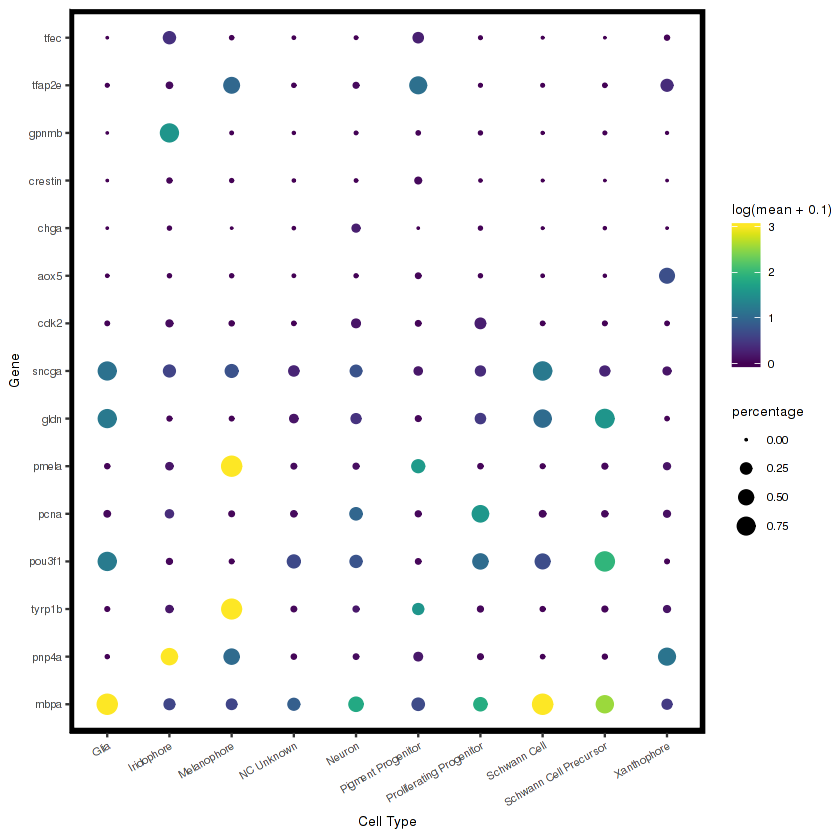

In [32]:
#png("Plots/euth_hypo_all-cell_marker_dotplot.png", units = "in", width = 5, height = 3, res = 500)
plot_markers_by_group(NC_cds, ls_genes, group_by = 'Cell_type_sub',
                      ordering_type = 'maximal_on_diag', max.size = 5) +
    theme(text = element_text(size = 8),
         panel.border = element_rect(colour = "black", fill=NA, size = 2)) +
    xlab("Cell Type")
#dev.off()

Warning message in if (axis_order == "marker_group") {:
“the condition has length > 1 and only the first element will be used”

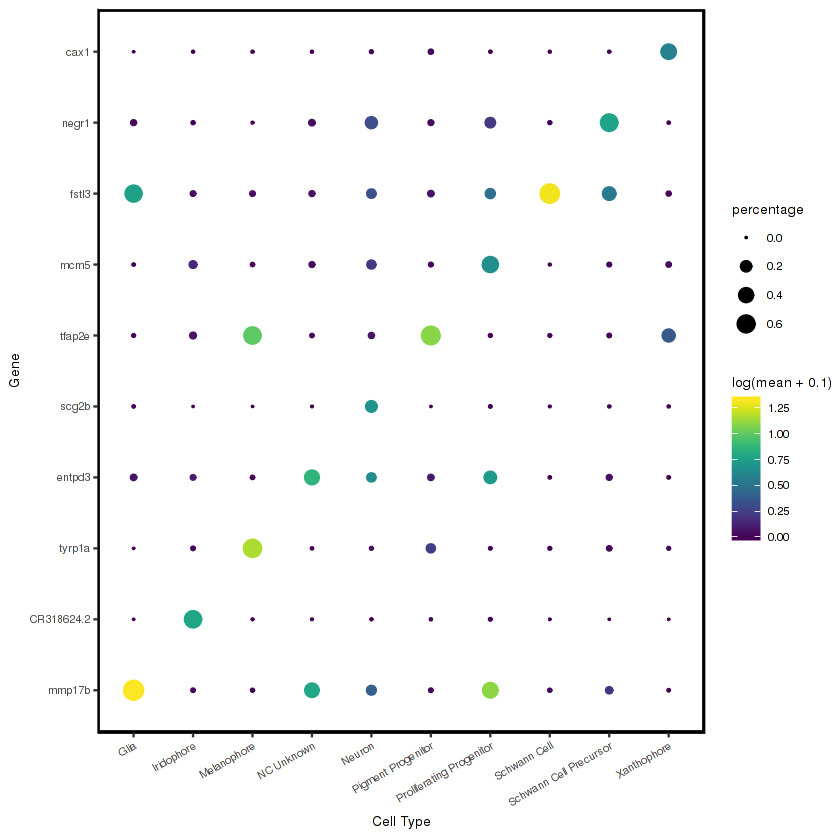

In [28]:
#png("Plots/euth_hypo_all-cell_marker_dotplot.png", units = "in", width = 5, height = 3, res = 500)
plot_markers_by_group(NC_cds, genes$gene_short_name, group_by = 'Cell_type_sub',
                      ordering_type = 'maximal_on_diag', max.size = 5) +
    theme(text = element_text(size = 8),
         panel.border = element_rect(colour = "black", fill=NA, size=1)) +
    xlab("Cell Type")
#dev.off()

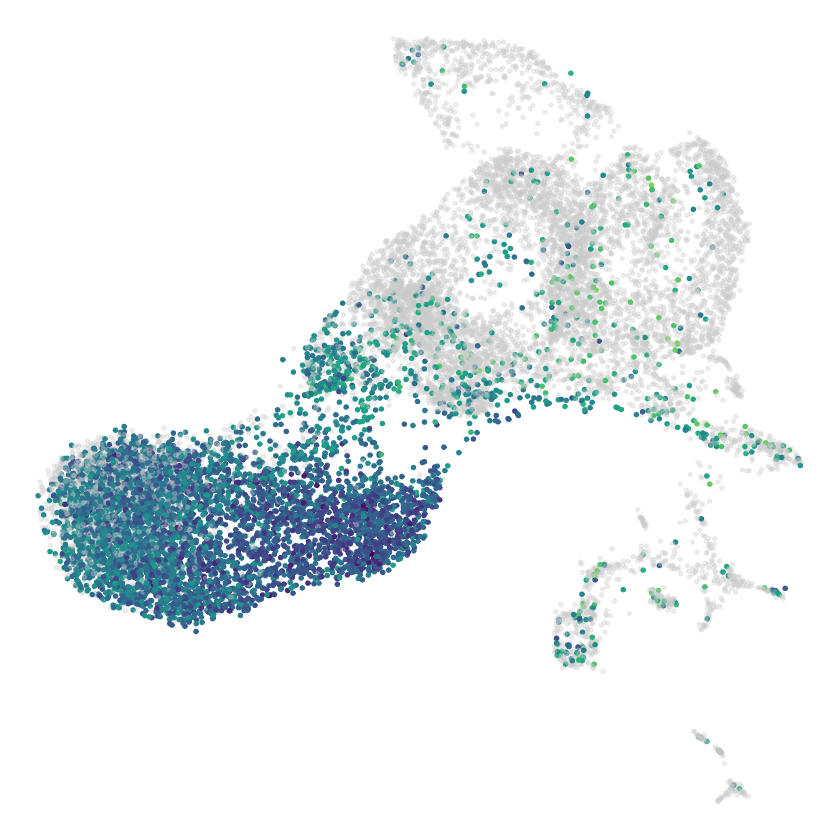

In [30]:
plot_grey_marker_umap(NC_cds, "fstl3")

### Testing cell cycle-based clustering hypothesis

In [ ]:
cds_sub <- NC_cds[,pData(NC_cds)$Cell_type_sub %in% c("Melanophore", "Iridophore", 
                                                    "Xanthophore", "Proliferating Progenitor",
                                                     "Pigment progenitor", "Progenitor 1 (G2/mitosis)")]

In [ ]:
unique(pData(cds_sub)$Cell_type_sub)

In [ ]:
cds_sub <- detectGenes(cds_sub, 0.1)
cds_sub <- estimateSizeFactors(cds_sub)
cds_sub <- estimateDispersions(cds_sub)

In [ ]:
### this takes a while to run, and this plot is saved already
pdf("Plots/pc-variance_plot.pdf")
plot_pc_variance_explained(cds_sub, return_all = F)
dev.off()

In [ ]:
# make ordering gene list without cell cycle genes
expr_genes_wo_cc <- row.names(subset(fData(cds_sub), num_cells_expressed >= 5))

cc_genes <- read.csv("cell_cycle_genes.csv", stringsAsFactors = FALSE) %>% select(gene_short_name = name)
tmp <- left_join(cc_genes, fData(cds_sub), by = "gene_short_name") %>% select(id)

expr_genes_wo_cc <- setdiff(expr_genes_wo_cc, tmp[,1])

In [ ]:
cds_sub <- setOrderingFilter(cds_sub, expr_genes_wo_cc)

In [ ]:
cds_sub <- reduceDimension(cds_sub, max_components = 2, num_dim = 25,
            reduction_method = 'tSNE', verbose = T)

pData(cds_sub)$tsne_1 = reducedDimA(cds_sub)[1,]
pData(cds_sub)$tsne_2 = reducedDimA(cds_sub)[2,]

In [ ]:
cds_sub <- clusterCells(cds_sub, verbose = T)

In [ ]:
plot_rho_delta(cds_sub, rho_threshold = 100, delta_threshold = 5)

In [ ]:
cds_sub <- clusterCells(cds_sub, rho_threshold = 100, 
                            delta_threshold = 5, skip_rho_sigma = T)

In [ ]:
plot_cell_clusters(cds_sub, cell_size = 0.5, color_by = "Cluster") +
    theme(legend.position = "right", legend.key.height = unit(0.05, "npc")) +
    labs(color="Cluster") +
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    ggsave("Plots/euth_hypo_pigment-prog_no-CC-genes_tSNE-cluster.pdf", width = 6, height = 5)

plot_cell_clusters(cds_sub, cell_size = 0.5, color_by = "Cell_type_sub") +
    theme(legend.position = "right", legend.key.height = unit(0.05, "npc")) +
    labs(color="Cluster") +
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    ggsave("Plots/euth_hypo_pigment-prog_no-CC-genes_tSNE-cellType.pdf", width = 7, height = 5)

### Try same subset without removing cell cycle genes

In [ ]:
cds_sub2 <- NC_cds[,pData(NC_cds)$Cell_type_sub %in% c("Melanophore", "Iridophore", 
                                                    "Xanthophore", "Proliferating Progenitor",
                                                     "Pigment progenitor", "Progenitor 1 (G2/mitosis)")]

In [ ]:
cds_sub2 <- detectGenes(cds_sub2, 0.1)
cds_sub2 <- estimateSizeFactors(cds_sub2)
cds_sub2 <- estimateDispersions(cds_sub2)

In [ ]:
# make ordering gene list of expressed genes
expr_genes <- row.names(subset(fData(cds_sub2), num_cells_expressed >= 5))

In [ ]:
cds_sub2 <- setOrderingFilter(cds_sub2, expr_genes)

In [ ]:
cds_sub2 <- reduceDimension(cds_sub2, max_components = 2, num_dim = 25,
            reduction_method = 'tSNE', verbose = T)

pData(cds_sub2)$tsne_1 = reducedDimA(cds_sub2)[1,]
pData(cds_sub2)$tsne_2 = reducedDimA(cds_sub2)[2,]

In [ ]:
cds_sub2 <- clusterCells(cds_sub2, verbose = T)

In [ ]:
plot_rho_delta(cds_sub2, rho_threshold = 100, delta_threshold = 5)

In [ ]:
cds_sub2 <- clusterCells(cds_sub2, rho_threshold = 100, 
                            delta_threshold = 5, skip_rho_sigma = T)

In [ ]:
plot_cell_clusters(cds_sub2, cell_size = 0.5, color_by = "Cluster") +
    theme(legend.position = "right", legend.key.height = unit(0.05, "npc")) +
    labs(color="Cluster") +
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    ggsave("Plots/euth_hypo_pigment-prog_yes-CC-genes_tSNE-cluster.pdf", width = 6, height = 5)

plot_cell_clusters(cds_sub2, cell_size = 0.5, color_by = "Cell_type_sub") +
    theme(legend.position = "right", legend.key.height = unit(0.05, "npc")) +
    labs(color="Cluster") +
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    ggsave("Plots/euth_hypo_pigment-prog_yes-CC-genes_tSNE-cellType.pdf", width = 7, height = 5)

### Output expression matricies for spring

In [ ]:
mat <- (as.matrix(Biobase::exprs(NC_cds)))

In [ ]:
df <- fData(NC_cds)
df <- df[rownames(mat),]

In [ ]:
dim(df)

In [ ]:
dim(mat)

In [ ]:
rownames(mat) <- df[,"gene_short_name"]

In [ ]:
write.csv(mat, "euth_hypo_NC_exprs_mat.csv")

In [ ]:
write.table(df[,"gene_short_name"], file = "NC_gene_names.csv", sep = ",", row.names = FALSE, col.names = FALSE)

In [ ]:
pdat <- pData(NC_cds) %>% select(condition, Cluster, Cell_type, Cell_type_sub) %>% 
        tibble::rownames_to_column("cell")

In [ ]:
write.table(t(pdat), file="horiz_NC_pDat.csv",sep=",", col.names = FALSE)
# this didn't work